In [1]:
%pylab inline
import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
from IPython.display import clear_output
import time
#from time import sleep
import numpy as np
import pandas as pd
from sklearn import linear_model
import math
import gym
import myfrozen
import pickle

Populating the interactive namespace from numpy and matplotlib


In [2]:
import img_utils

In [3]:
pkl_file = open('saved/collected.pkl', 'rb')
full = pickle.load(pkl_file)
pkl_file2 = open('saved/collected2.pkl', 'rb')
full2 = pickle.load(pkl_file2)

/anaconda/envs/drl/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator LinearRegression from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [1]:
def get_data(dictionary):
    X_train = np.zeros((100,64))
    i = 0
    for k, v in dictionary.items():
        for kp, vp in v.items():
            if kp == 'policy':
                X_train[i,:] = vp
                i += 1
    return X_train

def mix_data():
    x = get_data(full)
    y = get_data(full2)
    z = np.concatenate((x, y))
    return z

In [2]:
z = mix_data()

NameError: global name 'full' is not defined

In [7]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Lambda
from keras.layers.advanced_activations import LeakyReLU, Softmax
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
from keras.utils.np_utils import to_categorical
from keras import backend as K

import matplotlib.pyplot as plt

import sys

import numpy as np

In [22]:
class GAN():
    def __init__(self):
        self.img_rows = 64
        self.img_cols = 4
        self.img_shape = (self.img_rows, self.img_cols)
        self.latent_dim = 8

        optimizer = Adam(0.0002)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        #self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
    def build_generator(self):

        model = Sequential()
        
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='relu'))
        model.add(Reshape(self.img_shape))
        model.add(Lambda(lambda x: K.tf.nn.softmax(x)))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        
        return Model(noise, img)
    
    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)
    
    def train(self, epochs, batch_size=128, sample_interval=50):
    
        D = {}
        X_train = mix_data()
        X_train = to_categorical(X_train)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)
            # Train the discriminator 
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                D = self.sample_images(epoch,D)
                
        return D
                
    def sample_images(self, epoch, D):
                    
        def show_policy(q):
            A2A=['<','v','>','^']
            grid = np.zeros(64, dtype='<U2')
            for index in xrange(64):
                action = np.argmax(q[index,:])
                grid[index] = A2A[action]
            grid = np.reshape(grid, (8, 8), order='C')
            print(grid)
            return grid

        r, c = 1, 1
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        print(gen_imgs.shape)
        
        D[str(epoch)] = {}
        D[str(epoch)]["policy"] = gen_imgs
        print(gen_imgs.shape)
        _ = show_policy(np.squeeze(gen_imgs, axis=0))
        
        return D

In [23]:
gan = GAN()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 257       
Total params: 66,049
Trainable params: 66,049
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 256)               2304      
_________________________________________________________________
leaky_

In [24]:
# Without training discriminator (printing POLICY)
Dtest = gan.train(epochs=10000, batch_size=30, sample_interval=500)

0 [D loss: 0.831640, acc.: 10.00%] [G loss: 0.671412]
(1, 64, 4)
(1, 64, 4)
[[u'<' u'<' u'v' u'<' u'^' u'>' u'<' u'^']
 [u'<' u'v' u'<' u'<' u'v' u'>' u'>' u'v']
 [u'v' u'<' u'^' u'^' u'v' u'^' u'>' u'v']
 [u'>' u'<' u'<' u'<' u'<' u'v' u'^' u'<']
 [u'v' u'v' u'>' u'v' u'<' u'v' u'<' u'^']
 [u'^' u'^' u'>' u'^' u'>' u'<' u'>' u'>']
 [u'>' u'v' u'v' u'<' u'>' u'<' u'<' u'^']
 [u'<' u'>' u'<' u'<' u'<' u'^' u'v' u'>']]
1 [D loss: 0.807113, acc.: 18.33%] [G loss: 0.641216]
2 [D loss: 0.807454, acc.: 6.67%] [G loss: 0.638340]
3 [D loss: 0.773036, acc.: 18.33%] [G loss: 0.622719]
4 [D loss: 0.743946, acc.: 28.33%] [G loss: 0.617418]
5 [D loss: 0.741875, acc.: 33.33%] [G loss: 0.605271]
6 [D loss: 0.719890, acc.: 36.67%] [G loss: 0.600145]
7 [D loss: 0.732309, acc.: 36.67%] [G loss: 0.589042]
8 [D loss: 0.681216, acc.: 41.67%] [G loss: 0.598390]
9 [D loss: 0.693161, acc.: 45.00%] [G loss: 0.592559]
10 [D loss: 0.682900, acc.: 48.33%] [G loss: 0.616479]
11 [D loss: 0.624193, acc.: 53.33%] [G 

144 [D loss: 0.467774, acc.: 76.67%] [G loss: 1.280120]
145 [D loss: 0.565496, acc.: 75.00%] [G loss: 1.349112]
146 [D loss: 0.473352, acc.: 75.00%] [G loss: 1.252581]
147 [D loss: 0.633513, acc.: 70.00%] [G loss: 1.231864]
148 [D loss: 0.422042, acc.: 81.67%] [G loss: 1.386986]
149 [D loss: 0.491608, acc.: 80.00%] [G loss: 1.248720]
150 [D loss: 0.477626, acc.: 78.33%] [G loss: 1.200325]
151 [D loss: 0.523022, acc.: 71.67%] [G loss: 1.277571]
152 [D loss: 0.446058, acc.: 85.00%] [G loss: 1.250121]
153 [D loss: 0.425825, acc.: 86.67%] [G loss: 1.273590]
154 [D loss: 0.527131, acc.: 80.00%] [G loss: 1.224117]
155 [D loss: 0.416965, acc.: 86.67%] [G loss: 1.264856]
156 [D loss: 0.492676, acc.: 68.33%] [G loss: 1.159705]
157 [D loss: 0.491939, acc.: 73.33%] [G loss: 1.215120]
158 [D loss: 0.479597, acc.: 81.67%] [G loss: 1.209440]
159 [D loss: 0.523603, acc.: 78.33%] [G loss: 1.286228]
160 [D loss: 0.555932, acc.: 80.00%] [G loss: 1.221328]
161 [D loss: 0.455479, acc.: 81.67%] [G loss: 1.

295 [D loss: 0.546114, acc.: 80.00%] [G loss: 1.001530]
296 [D loss: 0.551993, acc.: 75.00%] [G loss: 1.014066]
297 [D loss: 0.554929, acc.: 76.67%] [G loss: 1.014663]
298 [D loss: 0.544487, acc.: 78.33%] [G loss: 0.987387]
299 [D loss: 0.545406, acc.: 80.00%] [G loss: 0.965941]
300 [D loss: 0.527486, acc.: 76.67%] [G loss: 0.967990]
301 [D loss: 0.493171, acc.: 88.33%] [G loss: 1.038906]
302 [D loss: 0.546895, acc.: 75.00%] [G loss: 1.068554]
303 [D loss: 0.596307, acc.: 73.33%] [G loss: 1.107471]
304 [D loss: 0.547563, acc.: 73.33%] [G loss: 1.059589]
305 [D loss: 0.604013, acc.: 73.33%] [G loss: 1.030867]
306 [D loss: 0.472021, acc.: 86.67%] [G loss: 1.134365]
307 [D loss: 0.509093, acc.: 80.00%] [G loss: 1.129018]
308 [D loss: 0.541752, acc.: 76.67%] [G loss: 1.097815]
309 [D loss: 0.502033, acc.: 78.33%] [G loss: 1.112704]
310 [D loss: 0.547358, acc.: 75.00%] [G loss: 1.126856]
311 [D loss: 0.521787, acc.: 75.00%] [G loss: 1.134523]
312 [D loss: 0.537591, acc.: 73.33%] [G loss: 1.

443 [D loss: 0.568634, acc.: 73.33%] [G loss: 1.020856]
444 [D loss: 0.552765, acc.: 78.33%] [G loss: 1.076151]
445 [D loss: 0.478411, acc.: 86.67%] [G loss: 1.040670]
446 [D loss: 0.513514, acc.: 83.33%] [G loss: 1.029883]
447 [D loss: 0.582163, acc.: 70.00%] [G loss: 1.032675]
448 [D loss: 0.551282, acc.: 73.33%] [G loss: 1.043682]
449 [D loss: 0.574526, acc.: 75.00%] [G loss: 1.018684]
450 [D loss: 0.560523, acc.: 81.67%] [G loss: 0.971441]
451 [D loss: 0.554087, acc.: 75.00%] [G loss: 0.955296]
452 [D loss: 0.549709, acc.: 73.33%] [G loss: 0.990520]
453 [D loss: 0.543723, acc.: 83.33%] [G loss: 1.018878]
454 [D loss: 0.542977, acc.: 68.33%] [G loss: 1.039881]
455 [D loss: 0.573131, acc.: 71.67%] [G loss: 0.960533]
456 [D loss: 0.553341, acc.: 78.33%] [G loss: 1.007318]
457 [D loss: 0.527924, acc.: 81.67%] [G loss: 0.997123]
458 [D loss: 0.560917, acc.: 78.33%] [G loss: 1.005542]
459 [D loss: 0.546814, acc.: 86.67%] [G loss: 0.924379]
460 [D loss: 0.512192, acc.: 83.33%] [G loss: 0.

587 [D loss: 0.534846, acc.: 80.00%] [G loss: 0.957816]
588 [D loss: 0.521248, acc.: 75.00%] [G loss: 0.954568]
589 [D loss: 0.531106, acc.: 83.33%] [G loss: 0.972976]
590 [D loss: 0.577954, acc.: 75.00%] [G loss: 0.923361]
591 [D loss: 0.535817, acc.: 85.00%] [G loss: 0.964079]
592 [D loss: 0.528625, acc.: 85.00%] [G loss: 0.966164]
593 [D loss: 0.549292, acc.: 78.33%] [G loss: 0.971992]
594 [D loss: 0.524554, acc.: 85.00%] [G loss: 0.942865]
595 [D loss: 0.571593, acc.: 76.67%] [G loss: 0.931126]
596 [D loss: 0.549405, acc.: 76.67%] [G loss: 0.966504]
597 [D loss: 0.514212, acc.: 88.33%] [G loss: 0.905258]
598 [D loss: 0.584244, acc.: 71.67%] [G loss: 0.949156]
599 [D loss: 0.594674, acc.: 85.00%] [G loss: 0.956290]
600 [D loss: 0.586015, acc.: 73.33%] [G loss: 0.956180]
601 [D loss: 0.563077, acc.: 81.67%] [G loss: 0.935060]
602 [D loss: 0.558478, acc.: 71.67%] [G loss: 0.920736]
603 [D loss: 0.533320, acc.: 81.67%] [G loss: 1.040823]
604 [D loss: 0.508298, acc.: 81.67%] [G loss: 1.

737 [D loss: 0.441457, acc.: 95.00%] [G loss: 1.004574]
738 [D loss: 0.518450, acc.: 78.33%] [G loss: 1.060262]
739 [D loss: 0.503897, acc.: 85.00%] [G loss: 1.012293]
740 [D loss: 0.465007, acc.: 90.00%] [G loss: 0.980522]
741 [D loss: 0.527511, acc.: 76.67%] [G loss: 1.049321]
742 [D loss: 0.509015, acc.: 80.00%] [G loss: 1.020035]
743 [D loss: 0.467556, acc.: 88.33%] [G loss: 1.020335]
744 [D loss: 0.480480, acc.: 85.00%] [G loss: 1.149312]
745 [D loss: 0.470547, acc.: 88.33%] [G loss: 1.044635]
746 [D loss: 0.470673, acc.: 85.00%] [G loss: 1.070102]
747 [D loss: 0.450829, acc.: 91.67%] [G loss: 1.025921]
748 [D loss: 0.455497, acc.: 90.00%] [G loss: 1.041712]
749 [D loss: 0.447047, acc.: 90.00%] [G loss: 1.046600]
750 [D loss: 0.490839, acc.: 83.33%] [G loss: 1.112974]
751 [D loss: 0.481240, acc.: 85.00%] [G loss: 1.059291]
752 [D loss: 0.487090, acc.: 88.33%] [G loss: 1.054765]
753 [D loss: 0.495801, acc.: 85.00%] [G loss: 1.095327]
754 [D loss: 0.486831, acc.: 86.67%] [G loss: 1.

884 [D loss: 0.515783, acc.: 83.33%] [G loss: 1.092469]
885 [D loss: 0.565724, acc.: 78.33%] [G loss: 0.955164]
886 [D loss: 0.492631, acc.: 85.00%] [G loss: 0.997058]
887 [D loss: 0.540391, acc.: 80.00%] [G loss: 0.962627]
888 [D loss: 0.553695, acc.: 86.67%] [G loss: 0.979685]
889 [D loss: 0.529789, acc.: 85.00%] [G loss: 0.983979]
890 [D loss: 0.470811, acc.: 86.67%] [G loss: 0.900952]
891 [D loss: 0.508383, acc.: 86.67%] [G loss: 0.921936]
892 [D loss: 0.538764, acc.: 85.00%] [G loss: 0.919265]
893 [D loss: 0.538701, acc.: 83.33%] [G loss: 0.966497]
894 [D loss: 0.579596, acc.: 78.33%] [G loss: 0.990738]
895 [D loss: 0.560501, acc.: 73.33%] [G loss: 0.895860]
896 [D loss: 0.539916, acc.: 73.33%] [G loss: 0.985398]
897 [D loss: 0.611866, acc.: 70.00%] [G loss: 0.914838]
898 [D loss: 0.592907, acc.: 75.00%] [G loss: 0.992092]
899 [D loss: 0.503136, acc.: 83.33%] [G loss: 0.891065]
900 [D loss: 0.498687, acc.: 86.67%] [G loss: 0.952863]
901 [D loss: 0.519384, acc.: 83.33%] [G loss: 0.

1026 [D loss: 0.559453, acc.: 71.67%] [G loss: 0.970899]
1027 [D loss: 0.545219, acc.: 73.33%] [G loss: 0.942819]
1028 [D loss: 0.537832, acc.: 73.33%] [G loss: 0.980039]
1029 [D loss: 0.584415, acc.: 65.00%] [G loss: 0.928542]
1030 [D loss: 0.558769, acc.: 71.67%] [G loss: 0.924325]
1031 [D loss: 0.555667, acc.: 76.67%] [G loss: 0.864840]
1032 [D loss: 0.555033, acc.: 73.33%] [G loss: 0.942355]
1033 [D loss: 0.532226, acc.: 75.00%] [G loss: 0.985591]
1034 [D loss: 0.548720, acc.: 76.67%] [G loss: 1.037220]
1035 [D loss: 0.562005, acc.: 70.00%] [G loss: 0.962760]
1036 [D loss: 0.587755, acc.: 76.67%] [G loss: 0.911038]
1037 [D loss: 0.563313, acc.: 83.33%] [G loss: 0.900684]
1038 [D loss: 0.585831, acc.: 80.00%] [G loss: 0.878261]
1039 [D loss: 0.533224, acc.: 78.33%] [G loss: 0.923794]
1040 [D loss: 0.573903, acc.: 68.33%] [G loss: 0.900260]
1041 [D loss: 0.588588, acc.: 63.33%] [G loss: 0.900634]
1042 [D loss: 0.623301, acc.: 65.00%] [G loss: 0.903376]
1043 [D loss: 0.625583, acc.: 6

1174 [D loss: 0.539586, acc.: 80.00%] [G loss: 1.007604]
1175 [D loss: 0.525249, acc.: 76.67%] [G loss: 0.964224]
1176 [D loss: 0.518172, acc.: 83.33%] [G loss: 0.963360]
1177 [D loss: 0.524549, acc.: 78.33%] [G loss: 0.970106]
1178 [D loss: 0.523771, acc.: 80.00%] [G loss: 0.957233]
1179 [D loss: 0.583504, acc.: 71.67%] [G loss: 0.910345]
1180 [D loss: 0.498799, acc.: 88.33%] [G loss: 0.976825]
1181 [D loss: 0.510508, acc.: 81.67%] [G loss: 1.004043]
1182 [D loss: 0.558194, acc.: 80.00%] [G loss: 0.901814]
1183 [D loss: 0.522093, acc.: 83.33%] [G loss: 0.966656]
1184 [D loss: 0.579934, acc.: 73.33%] [G loss: 0.952400]
1185 [D loss: 0.568590, acc.: 68.33%] [G loss: 0.919166]
1186 [D loss: 0.563145, acc.: 76.67%] [G loss: 0.973283]
1187 [D loss: 0.536732, acc.: 78.33%] [G loss: 0.965874]
1188 [D loss: 0.553167, acc.: 75.00%] [G loss: 0.967781]
1189 [D loss: 0.547382, acc.: 75.00%] [G loss: 0.931726]
1190 [D loss: 0.553571, acc.: 73.33%] [G loss: 0.917396]
1191 [D loss: 0.578197, acc.: 7

1318 [D loss: 0.451512, acc.: 88.33%] [G loss: 1.032503]
1319 [D loss: 0.485280, acc.: 83.33%] [G loss: 1.045793]
1320 [D loss: 0.505197, acc.: 81.67%] [G loss: 1.049302]
1321 [D loss: 0.425346, acc.: 90.00%] [G loss: 1.046667]
1322 [D loss: 0.460055, acc.: 91.67%] [G loss: 1.049757]
1323 [D loss: 0.510694, acc.: 76.67%] [G loss: 1.092883]
1324 [D loss: 0.511767, acc.: 78.33%] [G loss: 1.100080]
1325 [D loss: 0.485230, acc.: 81.67%] [G loss: 1.106632]
1326 [D loss: 0.481743, acc.: 90.00%] [G loss: 1.071037]
1327 [D loss: 0.457119, acc.: 86.67%] [G loss: 1.132886]
1328 [D loss: 0.473801, acc.: 85.00%] [G loss: 1.083027]
1329 [D loss: 0.475131, acc.: 90.00%] [G loss: 1.107805]
1330 [D loss: 0.529246, acc.: 81.67%] [G loss: 1.146412]
1331 [D loss: 0.505126, acc.: 83.33%] [G loss: 1.079358]
1332 [D loss: 0.452265, acc.: 91.67%] [G loss: 1.070967]
1333 [D loss: 0.456968, acc.: 88.33%] [G loss: 1.122405]
1334 [D loss: 0.461415, acc.: 88.33%] [G loss: 1.122594]
1335 [D loss: 0.437036, acc.: 9

1464 [D loss: 0.542300, acc.: 75.00%] [G loss: 0.939956]
1465 [D loss: 0.495833, acc.: 85.00%] [G loss: 0.970746]
1466 [D loss: 0.589786, acc.: 68.33%] [G loss: 1.014612]
1467 [D loss: 0.507597, acc.: 76.67%] [G loss: 0.965069]
1468 [D loss: 0.501785, acc.: 83.33%] [G loss: 0.997419]
1469 [D loss: 0.544474, acc.: 71.67%] [G loss: 1.001570]
1470 [D loss: 0.541145, acc.: 78.33%] [G loss: 0.989545]
1471 [D loss: 0.509316, acc.: 85.00%] [G loss: 0.916139]
1472 [D loss: 0.552251, acc.: 78.33%] [G loss: 0.908654]
1473 [D loss: 0.528705, acc.: 83.33%] [G loss: 0.987093]
1474 [D loss: 0.525488, acc.: 78.33%] [G loss: 0.990065]
1475 [D loss: 0.525905, acc.: 81.67%] [G loss: 0.932598]
1476 [D loss: 0.512480, acc.: 83.33%] [G loss: 0.936086]
1477 [D loss: 0.515278, acc.: 85.00%] [G loss: 0.896476]
1478 [D loss: 0.526605, acc.: 81.67%] [G loss: 1.015471]
1479 [D loss: 0.499115, acc.: 86.67%] [G loss: 0.934779]
1480 [D loss: 0.513193, acc.: 90.00%] [G loss: 0.942258]
1481 [D loss: 0.564735, acc.: 7

1603 [D loss: 0.462237, acc.: 88.33%] [G loss: 1.016825]
1604 [D loss: 0.483759, acc.: 90.00%] [G loss: 0.962284]
1605 [D loss: 0.493597, acc.: 83.33%] [G loss: 1.064981]
1606 [D loss: 0.485108, acc.: 88.33%] [G loss: 0.952475]
1607 [D loss: 0.521426, acc.: 83.33%] [G loss: 0.985769]
1608 [D loss: 0.476498, acc.: 85.00%] [G loss: 0.992667]
1609 [D loss: 0.550813, acc.: 78.33%] [G loss: 1.012802]
1610 [D loss: 0.549787, acc.: 85.00%] [G loss: 0.995209]
1611 [D loss: 0.522389, acc.: 80.00%] [G loss: 0.958491]
1612 [D loss: 0.542898, acc.: 78.33%] [G loss: 0.977988]
1613 [D loss: 0.501583, acc.: 81.67%] [G loss: 0.952288]
1614 [D loss: 0.566005, acc.: 70.00%] [G loss: 0.950907]
1615 [D loss: 0.682386, acc.: 60.00%] [G loss: 0.903216]
1616 [D loss: 0.614354, acc.: 65.00%] [G loss: 0.910961]
1617 [D loss: 0.534516, acc.: 81.67%] [G loss: 0.913896]
1618 [D loss: 0.583581, acc.: 71.67%] [G loss: 0.865616]
1619 [D loss: 0.638552, acc.: 61.67%] [G loss: 0.954312]
1620 [D loss: 0.558941, acc.: 7

1750 [D loss: 0.484406, acc.: 88.33%] [G loss: 1.073287]
1751 [D loss: 0.437289, acc.: 91.67%] [G loss: 1.055370]
1752 [D loss: 0.425870, acc.: 91.67%] [G loss: 1.120250]
1753 [D loss: 0.480781, acc.: 86.67%] [G loss: 1.048190]
1754 [D loss: 0.494419, acc.: 83.33%] [G loss: 1.045214]
1755 [D loss: 0.497581, acc.: 86.67%] [G loss: 1.085111]
1756 [D loss: 0.488204, acc.: 85.00%] [G loss: 1.054230]
1757 [D loss: 0.489703, acc.: 85.00%] [G loss: 1.082570]
1758 [D loss: 0.523649, acc.: 83.33%] [G loss: 1.035766]
1759 [D loss: 0.436817, acc.: 91.67%] [G loss: 1.072999]
1760 [D loss: 0.501030, acc.: 81.67%] [G loss: 1.021237]
1761 [D loss: 0.498048, acc.: 83.33%] [G loss: 1.055378]
1762 [D loss: 0.529608, acc.: 76.67%] [G loss: 0.988190]
1763 [D loss: 0.596150, acc.: 68.33%] [G loss: 1.036754]
1764 [D loss: 0.458795, acc.: 85.00%] [G loss: 1.033807]
1765 [D loss: 0.482773, acc.: 78.33%] [G loss: 1.039792]
1766 [D loss: 0.477413, acc.: 83.33%] [G loss: 0.988659]
1767 [D loss: 0.528085, acc.: 7

1896 [D loss: 0.540490, acc.: 71.67%] [G loss: 0.929932]
1897 [D loss: 0.538630, acc.: 80.00%] [G loss: 0.937050]
1898 [D loss: 0.540156, acc.: 71.67%] [G loss: 1.022861]
1899 [D loss: 0.531571, acc.: 83.33%] [G loss: 0.970881]
1900 [D loss: 0.471864, acc.: 85.00%] [G loss: 0.977896]
1901 [D loss: 0.561099, acc.: 71.67%] [G loss: 0.892599]
1902 [D loss: 0.512076, acc.: 78.33%] [G loss: 1.048583]
1903 [D loss: 0.505242, acc.: 80.00%] [G loss: 0.970790]
1904 [D loss: 0.522384, acc.: 76.67%] [G loss: 0.990798]
1905 [D loss: 0.521975, acc.: 78.33%] [G loss: 1.032866]
1906 [D loss: 0.506860, acc.: 76.67%] [G loss: 1.048024]
1907 [D loss: 0.588387, acc.: 75.00%] [G loss: 0.989332]
1908 [D loss: 0.611700, acc.: 68.33%] [G loss: 0.951876]
1909 [D loss: 0.555214, acc.: 75.00%] [G loss: 0.963277]
1910 [D loss: 0.541721, acc.: 80.00%] [G loss: 0.971730]
1911 [D loss: 0.580070, acc.: 73.33%] [G loss: 0.926948]
1912 [D loss: 0.566051, acc.: 73.33%] [G loss: 1.009848]
1913 [D loss: 0.542714, acc.: 7

2036 [D loss: 0.494053, acc.: 88.33%] [G loss: 1.051188]
2037 [D loss: 0.481974, acc.: 86.67%] [G loss: 1.086881]
2038 [D loss: 0.510450, acc.: 76.67%] [G loss: 1.004992]
2039 [D loss: 0.464766, acc.: 81.67%] [G loss: 1.003442]
2040 [D loss: 0.468599, acc.: 88.33%] [G loss: 1.111751]
2041 [D loss: 0.488522, acc.: 88.33%] [G loss: 1.065463]
2042 [D loss: 0.498669, acc.: 78.33%] [G loss: 1.079538]
2043 [D loss: 0.503696, acc.: 83.33%] [G loss: 1.096271]
2044 [D loss: 0.466774, acc.: 90.00%] [G loss: 1.080474]
2045 [D loss: 0.490900, acc.: 83.33%] [G loss: 1.050527]
2046 [D loss: 0.574355, acc.: 70.00%] [G loss: 1.079893]
2047 [D loss: 0.493883, acc.: 90.00%] [G loss: 1.033875]
2048 [D loss: 0.469172, acc.: 80.00%] [G loss: 1.060146]
2049 [D loss: 0.478987, acc.: 88.33%] [G loss: 1.065025]
2050 [D loss: 0.527158, acc.: 76.67%] [G loss: 1.036541]
2051 [D loss: 0.528646, acc.: 76.67%] [G loss: 1.002066]
2052 [D loss: 0.546075, acc.: 80.00%] [G loss: 1.021281]
2053 [D loss: 0.499265, acc.: 8

2183 [D loss: 0.487129, acc.: 88.33%] [G loss: 1.040083]
2184 [D loss: 0.488846, acc.: 86.67%] [G loss: 1.002634]
2185 [D loss: 0.465691, acc.: 90.00%] [G loss: 1.032886]
2186 [D loss: 0.484120, acc.: 83.33%] [G loss: 1.087175]
2187 [D loss: 0.458998, acc.: 91.67%] [G loss: 1.036707]
2188 [D loss: 0.478413, acc.: 85.00%] [G loss: 1.035140]
2189 [D loss: 0.481973, acc.: 81.67%] [G loss: 1.057820]
2190 [D loss: 0.444216, acc.: 88.33%] [G loss: 1.098742]
2191 [D loss: 0.462174, acc.: 85.00%] [G loss: 1.142668]
2192 [D loss: 0.466824, acc.: 88.33%] [G loss: 1.042935]
2193 [D loss: 0.486346, acc.: 83.33%] [G loss: 1.064339]
2194 [D loss: 0.536799, acc.: 75.00%] [G loss: 1.096760]
2195 [D loss: 0.474325, acc.: 85.00%] [G loss: 1.096761]
2196 [D loss: 0.540330, acc.: 81.67%] [G loss: 0.979508]
2197 [D loss: 0.488389, acc.: 83.33%] [G loss: 1.076093]
2198 [D loss: 0.514333, acc.: 86.67%] [G loss: 1.042268]
2199 [D loss: 0.504319, acc.: 81.67%] [G loss: 0.983522]
2200 [D loss: 0.493302, acc.: 8

2331 [D loss: 0.445642, acc.: 86.67%] [G loss: 1.124196]
2332 [D loss: 0.437568, acc.: 88.33%] [G loss: 1.244540]
2333 [D loss: 0.456609, acc.: 83.33%] [G loss: 1.114838]
2334 [D loss: 0.464929, acc.: 78.33%] [G loss: 1.203681]
2335 [D loss: 0.436678, acc.: 88.33%] [G loss: 1.119260]
2336 [D loss: 0.474890, acc.: 81.67%] [G loss: 1.143179]
2337 [D loss: 0.471603, acc.: 81.67%] [G loss: 1.160355]
2338 [D loss: 0.464787, acc.: 83.33%] [G loss: 1.163256]
2339 [D loss: 0.484677, acc.: 80.00%] [G loss: 1.090265]
2340 [D loss: 0.413276, acc.: 88.33%] [G loss: 1.092665]
2341 [D loss: 0.391353, acc.: 93.33%] [G loss: 1.098762]
2342 [D loss: 0.478478, acc.: 83.33%] [G loss: 1.212213]
2343 [D loss: 0.396456, acc.: 93.33%] [G loss: 1.177980]
2344 [D loss: 0.427565, acc.: 85.00%] [G loss: 1.127750]
2345 [D loss: 0.438896, acc.: 88.33%] [G loss: 1.192371]
2346 [D loss: 0.437423, acc.: 90.00%] [G loss: 1.201864]
2347 [D loss: 0.479530, acc.: 85.00%] [G loss: 1.229030]
2348 [D loss: 0.427859, acc.: 9

2476 [D loss: 0.475433, acc.: 88.33%] [G loss: 1.018236]
2477 [D loss: 0.514392, acc.: 80.00%] [G loss: 1.011268]
2478 [D loss: 0.543008, acc.: 83.33%] [G loss: 1.140494]
2479 [D loss: 0.545082, acc.: 73.33%] [G loss: 1.049330]
2480 [D loss: 0.520847, acc.: 81.67%] [G loss: 1.031898]
2481 [D loss: 0.476532, acc.: 85.00%] [G loss: 1.055764]
2482 [D loss: 0.529896, acc.: 81.67%] [G loss: 1.026003]
2483 [D loss: 0.553144, acc.: 75.00%] [G loss: 1.084183]
2484 [D loss: 0.505221, acc.: 86.67%] [G loss: 1.069063]
2485 [D loss: 0.469592, acc.: 81.67%] [G loss: 1.083079]
2486 [D loss: 0.487519, acc.: 81.67%] [G loss: 1.061829]
2487 [D loss: 0.461704, acc.: 83.33%] [G loss: 1.153010]
2488 [D loss: 0.419846, acc.: 88.33%] [G loss: 1.120143]
2489 [D loss: 0.420090, acc.: 95.00%] [G loss: 1.120589]
2490 [D loss: 0.532390, acc.: 81.67%] [G loss: 1.033196]
2491 [D loss: 0.517955, acc.: 83.33%] [G loss: 1.172889]
2492 [D loss: 0.417014, acc.: 90.00%] [G loss: 1.153855]
2493 [D loss: 0.467216, acc.: 8

2616 [D loss: 0.446078, acc.: 90.00%] [G loss: 1.143978]
2617 [D loss: 0.415588, acc.: 90.00%] [G loss: 1.097545]
2618 [D loss: 0.469331, acc.: 91.67%] [G loss: 1.127544]
2619 [D loss: 0.512773, acc.: 76.67%] [G loss: 1.102746]
2620 [D loss: 0.482115, acc.: 85.00%] [G loss: 1.152882]
2621 [D loss: 0.430791, acc.: 86.67%] [G loss: 1.043130]
2622 [D loss: 0.432775, acc.: 91.67%] [G loss: 1.081949]
2623 [D loss: 0.428763, acc.: 91.67%] [G loss: 1.032224]
2624 [D loss: 0.383890, acc.: 95.00%] [G loss: 1.150077]
2625 [D loss: 0.449519, acc.: 90.00%] [G loss: 1.043412]
2626 [D loss: 0.458222, acc.: 85.00%] [G loss: 1.051400]
2627 [D loss: 0.442874, acc.: 90.00%] [G loss: 1.096386]
2628 [D loss: 0.479321, acc.: 88.33%] [G loss: 1.154451]
2629 [D loss: 0.405017, acc.: 90.00%] [G loss: 1.029074]
2630 [D loss: 0.429405, acc.: 86.67%] [G loss: 1.090069]
2631 [D loss: 0.448084, acc.: 80.00%] [G loss: 1.106334]
2632 [D loss: 0.421716, acc.: 86.67%] [G loss: 1.105771]
2633 [D loss: 0.440911, acc.: 8

2764 [D loss: 0.462432, acc.: 83.33%] [G loss: 1.201436]
2765 [D loss: 0.428282, acc.: 83.33%] [G loss: 1.172136]
2766 [D loss: 0.430358, acc.: 86.67%] [G loss: 1.125241]
2767 [D loss: 0.469334, acc.: 80.00%] [G loss: 1.209042]
2768 [D loss: 0.420078, acc.: 90.00%] [G loss: 1.189461]
2769 [D loss: 0.505497, acc.: 75.00%] [G loss: 1.108368]
2770 [D loss: 0.468939, acc.: 80.00%] [G loss: 1.088781]
2771 [D loss: 0.470937, acc.: 81.67%] [G loss: 1.226219]
2772 [D loss: 0.436519, acc.: 86.67%] [G loss: 1.231362]
2773 [D loss: 0.440341, acc.: 83.33%] [G loss: 1.167552]
2774 [D loss: 0.462682, acc.: 83.33%] [G loss: 1.169457]
2775 [D loss: 0.475564, acc.: 80.00%] [G loss: 1.210039]
2776 [D loss: 0.435762, acc.: 83.33%] [G loss: 1.235605]
2777 [D loss: 0.464899, acc.: 81.67%] [G loss: 1.234577]
2778 [D loss: 0.455820, acc.: 85.00%] [G loss: 1.188978]
2779 [D loss: 0.489001, acc.: 80.00%] [G loss: 1.289989]
2780 [D loss: 0.487808, acc.: 76.67%] [G loss: 1.190684]
2781 [D loss: 0.466696, acc.: 8

2910 [D loss: 0.350693, acc.: 91.67%] [G loss: 1.227255]
2911 [D loss: 0.439822, acc.: 76.67%] [G loss: 1.423981]
2912 [D loss: 0.405134, acc.: 81.67%] [G loss: 1.261321]
2913 [D loss: 0.372874, acc.: 86.67%] [G loss: 1.346033]
2914 [D loss: 0.422580, acc.: 81.67%] [G loss: 1.400465]
2915 [D loss: 0.395625, acc.: 86.67%] [G loss: 1.342738]
2916 [D loss: 0.387075, acc.: 85.00%] [G loss: 1.274815]
2917 [D loss: 0.349059, acc.: 95.00%] [G loss: 1.236178]
2918 [D loss: 0.384724, acc.: 86.67%] [G loss: 1.356357]
2919 [D loss: 0.405282, acc.: 81.67%] [G loss: 1.249891]
2920 [D loss: 0.355991, acc.: 90.00%] [G loss: 1.282073]
2921 [D loss: 0.411296, acc.: 86.67%] [G loss: 1.264977]
2922 [D loss: 0.393480, acc.: 83.33%] [G loss: 1.297185]
2923 [D loss: 0.398096, acc.: 85.00%] [G loss: 1.221389]
2924 [D loss: 0.360228, acc.: 90.00%] [G loss: 1.303931]
2925 [D loss: 0.358772, acc.: 88.33%] [G loss: 1.250265]
2926 [D loss: 0.403183, acc.: 80.00%] [G loss: 1.167815]
2927 [D loss: 0.372539, acc.: 8

3052 [D loss: 0.421838, acc.: 88.33%] [G loss: 1.176867]
3053 [D loss: 0.402759, acc.: 81.67%] [G loss: 1.307781]
3054 [D loss: 0.422240, acc.: 85.00%] [G loss: 1.453959]
3055 [D loss: 0.386814, acc.: 83.33%] [G loss: 1.515987]
3056 [D loss: 0.432584, acc.: 83.33%] [G loss: 1.409415]
3057 [D loss: 0.364356, acc.: 90.00%] [G loss: 1.360372]
3058 [D loss: 0.454832, acc.: 83.33%] [G loss: 1.316782]
3059 [D loss: 0.416316, acc.: 81.67%] [G loss: 1.411886]
3060 [D loss: 0.345192, acc.: 90.00%] [G loss: 1.315839]
3061 [D loss: 0.371823, acc.: 90.00%] [G loss: 1.282379]
3062 [D loss: 0.365449, acc.: 83.33%] [G loss: 1.437567]
3063 [D loss: 0.338708, acc.: 86.67%] [G loss: 1.385932]
3064 [D loss: 0.431051, acc.: 88.33%] [G loss: 1.353873]
3065 [D loss: 0.391733, acc.: 83.33%] [G loss: 1.312989]
3066 [D loss: 0.377455, acc.: 88.33%] [G loss: 1.389509]
3067 [D loss: 0.373888, acc.: 86.67%] [G loss: 1.281198]
3068 [D loss: 0.370264, acc.: 83.33%] [G loss: 1.433317]
3069 [D loss: 0.334544, acc.: 9

3198 [D loss: 0.373320, acc.: 88.33%] [G loss: 1.246620]
3199 [D loss: 0.423785, acc.: 90.00%] [G loss: 1.227690]
3200 [D loss: 0.401217, acc.: 90.00%] [G loss: 1.296885]
3201 [D loss: 0.382529, acc.: 88.33%] [G loss: 1.269446]
3202 [D loss: 0.401729, acc.: 93.33%] [G loss: 1.212640]
3203 [D loss: 0.366747, acc.: 95.00%] [G loss: 1.258183]
3204 [D loss: 0.412381, acc.: 88.33%] [G loss: 1.231831]
3205 [D loss: 0.399278, acc.: 91.67%] [G loss: 1.241341]
3206 [D loss: 0.343029, acc.: 88.33%] [G loss: 1.348731]
3207 [D loss: 0.380506, acc.: 86.67%] [G loss: 1.285908]
3208 [D loss: 0.375612, acc.: 90.00%] [G loss: 1.300156]
3209 [D loss: 0.450554, acc.: 85.00%] [G loss: 1.364374]
3210 [D loss: 0.418843, acc.: 88.33%] [G loss: 1.386753]
3211 [D loss: 0.428215, acc.: 83.33%] [G loss: 1.346623]
3212 [D loss: 0.398169, acc.: 91.67%] [G loss: 1.337490]
3213 [D loss: 0.436131, acc.: 83.33%] [G loss: 1.319936]
3214 [D loss: 0.430873, acc.: 90.00%] [G loss: 1.359906]
3215 [D loss: 0.391387, acc.: 8

3344 [D loss: 0.352745, acc.: 95.00%] [G loss: 1.292295]
3345 [D loss: 0.383465, acc.: 96.67%] [G loss: 1.217812]
3346 [D loss: 0.355902, acc.: 91.67%] [G loss: 1.379910]
3347 [D loss: 0.380278, acc.: 95.00%] [G loss: 1.331707]
3348 [D loss: 0.313608, acc.: 93.33%] [G loss: 1.278450]
3349 [D loss: 0.379651, acc.: 90.00%] [G loss: 1.273365]
3350 [D loss: 0.394529, acc.: 88.33%] [G loss: 1.262079]
3351 [D loss: 0.356096, acc.: 90.00%] [G loss: 1.435424]
3352 [D loss: 0.369233, acc.: 91.67%] [G loss: 1.401752]
3353 [D loss: 0.310887, acc.: 93.33%] [G loss: 1.308065]
3354 [D loss: 0.395482, acc.: 88.33%] [G loss: 1.334169]
3355 [D loss: 0.375007, acc.: 91.67%] [G loss: 1.448893]
3356 [D loss: 0.329596, acc.: 96.67%] [G loss: 1.478664]
3357 [D loss: 0.332482, acc.: 93.33%] [G loss: 1.276253]
3358 [D loss: 0.380051, acc.: 86.67%] [G loss: 1.358474]
3359 [D loss: 0.335636, acc.: 96.67%] [G loss: 1.323206]
3360 [D loss: 0.373815, acc.: 91.67%] [G loss: 1.293817]
3361 [D loss: 0.355045, acc.: 9

3490 [D loss: 0.422171, acc.: 88.33%] [G loss: 1.400731]
3491 [D loss: 0.360951, acc.: 88.33%] [G loss: 1.353667]
3492 [D loss: 0.304277, acc.: 93.33%] [G loss: 1.335070]
3493 [D loss: 0.345457, acc.: 93.33%] [G loss: 1.209772]
3494 [D loss: 0.365338, acc.: 86.67%] [G loss: 1.344900]
3495 [D loss: 0.388890, acc.: 88.33%] [G loss: 1.291338]
3496 [D loss: 0.366123, acc.: 90.00%] [G loss: 1.379959]
3497 [D loss: 0.415033, acc.: 85.00%] [G loss: 1.287787]
3498 [D loss: 0.389039, acc.: 83.33%] [G loss: 1.288195]
3499 [D loss: 0.382458, acc.: 86.67%] [G loss: 1.378048]
3500 [D loss: 0.367830, acc.: 83.33%] [G loss: 1.260324]
(1, 64, 4)
(1, 64, 4)
[[u'>' u'v' u'v' u'v' u'<' u'v' u'<' u'v']
 [u'>' u'v' u'v' u'<' u'<' u'v' u'<' u'v']
 [u'<' u'v' u'v' u'>' u'<' u'v' u'<' u'<']
 [u'v' u'v' u'v' u'<' u'>' u'v' u'<' u'v']
 [u'v' u'>' u'v' u'<' u'v' u'<' u'v' u'<']
 [u'v' u'v' u'v' u'v' u'v' u'>' u'v' u'<']
 [u'v' u'v' u'v' u'v' u'v' u'v' u'v' u'<']
 [u'>' u'>' u'>' u'>' u'>' u'<' u'<' u'<']]
3501 [

3630 [D loss: 0.390173, acc.: 91.67%] [G loss: 1.225966]
3631 [D loss: 0.448760, acc.: 86.67%] [G loss: 1.163209]
3632 [D loss: 0.393036, acc.: 90.00%] [G loss: 1.212539]
3633 [D loss: 0.440692, acc.: 85.00%] [G loss: 1.265611]
3634 [D loss: 0.460220, acc.: 76.67%] [G loss: 1.275195]
3635 [D loss: 0.323241, acc.: 93.33%] [G loss: 1.267948]
3636 [D loss: 0.393608, acc.: 86.67%] [G loss: 1.251021]
3637 [D loss: 0.395918, acc.: 86.67%] [G loss: 1.278221]
3638 [D loss: 0.418906, acc.: 81.67%] [G loss: 1.222377]
3639 [D loss: 0.462914, acc.: 83.33%] [G loss: 1.256332]
3640 [D loss: 0.410906, acc.: 88.33%] [G loss: 1.345635]
3641 [D loss: 0.439066, acc.: 83.33%] [G loss: 1.399767]
3642 [D loss: 0.390496, acc.: 88.33%] [G loss: 1.278376]
3643 [D loss: 0.409967, acc.: 88.33%] [G loss: 1.227753]
3644 [D loss: 0.408331, acc.: 91.67%] [G loss: 1.189810]
3645 [D loss: 0.486001, acc.: 71.67%] [G loss: 1.267608]
3646 [D loss: 0.405821, acc.: 86.67%] [G loss: 1.212529]
3647 [D loss: 0.442997, acc.: 8

3776 [D loss: 0.522716, acc.: 80.00%] [G loss: 1.169353]
3777 [D loss: 0.459829, acc.: 86.67%] [G loss: 1.066352]
3778 [D loss: 0.430646, acc.: 85.00%] [G loss: 1.098428]
3779 [D loss: 0.521032, acc.: 83.33%] [G loss: 1.114212]
3780 [D loss: 0.408722, acc.: 88.33%] [G loss: 1.058079]
3781 [D loss: 0.402931, acc.: 93.33%] [G loss: 1.148635]
3782 [D loss: 0.451263, acc.: 81.67%] [G loss: 1.109525]
3783 [D loss: 0.461265, acc.: 83.33%] [G loss: 1.121151]
3784 [D loss: 0.438790, acc.: 85.00%] [G loss: 1.167926]
3785 [D loss: 0.468002, acc.: 81.67%] [G loss: 1.185101]
3786 [D loss: 0.395514, acc.: 90.00%] [G loss: 1.131442]
3787 [D loss: 0.444204, acc.: 80.00%] [G loss: 1.174764]
3788 [D loss: 0.487455, acc.: 76.67%] [G loss: 1.176750]
3789 [D loss: 0.488912, acc.: 78.33%] [G loss: 1.146133]
3790 [D loss: 0.444044, acc.: 86.67%] [G loss: 1.121874]
3791 [D loss: 0.414920, acc.: 88.33%] [G loss: 1.117498]
3792 [D loss: 0.470257, acc.: 78.33%] [G loss: 1.109543]
3793 [D loss: 0.490352, acc.: 8

3920 [D loss: 0.418216, acc.: 85.00%] [G loss: 1.356162]
3921 [D loss: 0.454062, acc.: 83.33%] [G loss: 1.409308]
3922 [D loss: 0.409553, acc.: 85.00%] [G loss: 1.319755]
3923 [D loss: 0.409981, acc.: 85.00%] [G loss: 1.283001]
3924 [D loss: 0.507001, acc.: 80.00%] [G loss: 1.267855]
3925 [D loss: 0.358900, acc.: 88.33%] [G loss: 1.302583]
3926 [D loss: 0.409839, acc.: 85.00%] [G loss: 1.242992]
3927 [D loss: 0.464437, acc.: 78.33%] [G loss: 1.224826]
3928 [D loss: 0.472131, acc.: 73.33%] [G loss: 1.198398]
3929 [D loss: 0.429297, acc.: 83.33%] [G loss: 1.187901]
3930 [D loss: 0.452311, acc.: 80.00%] [G loss: 1.199176]
3931 [D loss: 0.378701, acc.: 86.67%] [G loss: 1.247878]
3932 [D loss: 0.496570, acc.: 78.33%] [G loss: 1.133484]
3933 [D loss: 0.386622, acc.: 86.67%] [G loss: 1.281919]
3934 [D loss: 0.483919, acc.: 75.00%] [G loss: 1.192206]
3935 [D loss: 0.424156, acc.: 83.33%] [G loss: 1.157191]
3936 [D loss: 0.442834, acc.: 78.33%] [G loss: 1.281228]
3937 [D loss: 0.492782, acc.: 7

4060 [D loss: 0.385619, acc.: 85.00%] [G loss: 1.335040]
4061 [D loss: 0.313955, acc.: 98.33%] [G loss: 1.441371]
4062 [D loss: 0.348035, acc.: 90.00%] [G loss: 1.278771]
4063 [D loss: 0.394413, acc.: 86.67%] [G loss: 1.377248]
4064 [D loss: 0.360818, acc.: 90.00%] [G loss: 1.410160]
4065 [D loss: 0.361309, acc.: 85.00%] [G loss: 1.289466]
4066 [D loss: 0.371699, acc.: 90.00%] [G loss: 1.385754]
4067 [D loss: 0.291197, acc.: 93.33%] [G loss: 1.439257]
4068 [D loss: 0.343608, acc.: 88.33%] [G loss: 1.417822]
4069 [D loss: 0.316415, acc.: 91.67%] [G loss: 1.522934]
4070 [D loss: 0.402507, acc.: 85.00%] [G loss: 1.398218]
4071 [D loss: 0.327866, acc.: 95.00%] [G loss: 1.381631]
4072 [D loss: 0.325860, acc.: 85.00%] [G loss: 1.488364]
4073 [D loss: 0.319515, acc.: 95.00%] [G loss: 1.457938]
4074 [D loss: 0.318192, acc.: 91.67%] [G loss: 1.476389]
4075 [D loss: 0.355835, acc.: 86.67%] [G loss: 1.433216]
4076 [D loss: 0.395789, acc.: 86.67%] [G loss: 1.329830]
4077 [D loss: 0.351186, acc.: 9

4207 [D loss: 0.392429, acc.: 85.00%] [G loss: 1.418828]
4208 [D loss: 0.427267, acc.: 81.67%] [G loss: 1.401689]
4209 [D loss: 0.480518, acc.: 75.00%] [G loss: 1.390437]
4210 [D loss: 0.353775, acc.: 88.33%] [G loss: 1.230847]
4211 [D loss: 0.397414, acc.: 88.33%] [G loss: 1.316297]
4212 [D loss: 0.496940, acc.: 76.67%] [G loss: 1.268899]
4213 [D loss: 0.377309, acc.: 88.33%] [G loss: 1.160299]
4214 [D loss: 0.453420, acc.: 81.67%] [G loss: 1.223596]
4215 [D loss: 0.481605, acc.: 83.33%] [G loss: 1.138358]
4216 [D loss: 0.398957, acc.: 86.67%] [G loss: 1.236342]
4217 [D loss: 0.390150, acc.: 83.33%] [G loss: 1.247121]
4218 [D loss: 0.388821, acc.: 93.33%] [G loss: 1.238010]
4219 [D loss: 0.398103, acc.: 88.33%] [G loss: 1.450715]
4220 [D loss: 0.399086, acc.: 90.00%] [G loss: 1.279483]
4221 [D loss: 0.448038, acc.: 80.00%] [G loss: 1.296317]
4222 [D loss: 0.412034, acc.: 85.00%] [G loss: 1.339339]
4223 [D loss: 0.434390, acc.: 86.67%] [G loss: 1.255388]
4224 [D loss: 0.427022, acc.: 8

4354 [D loss: 0.384053, acc.: 85.00%] [G loss: 1.203718]
4355 [D loss: 0.439586, acc.: 81.67%] [G loss: 1.324378]
4356 [D loss: 0.442546, acc.: 83.33%] [G loss: 1.353680]
4357 [D loss: 0.412941, acc.: 86.67%] [G loss: 1.444534]
4358 [D loss: 0.413442, acc.: 88.33%] [G loss: 1.381757]
4359 [D loss: 0.383963, acc.: 90.00%] [G loss: 1.371715]
4360 [D loss: 0.420356, acc.: 85.00%] [G loss: 1.253680]
4361 [D loss: 0.293092, acc.: 95.00%] [G loss: 1.168435]
4362 [D loss: 0.402216, acc.: 85.00%] [G loss: 1.340222]
4363 [D loss: 0.418887, acc.: 90.00%] [G loss: 1.372655]
4364 [D loss: 0.417888, acc.: 85.00%] [G loss: 1.301945]
4365 [D loss: 0.355404, acc.: 86.67%] [G loss: 1.255468]
4366 [D loss: 0.344561, acc.: 90.00%] [G loss: 1.226190]
4367 [D loss: 0.415559, acc.: 81.67%] [G loss: 1.276010]
4368 [D loss: 0.418713, acc.: 86.67%] [G loss: 1.301891]
4369 [D loss: 0.408101, acc.: 80.00%] [G loss: 1.334396]
4370 [D loss: 0.430653, acc.: 85.00%] [G loss: 1.327789]
4371 [D loss: 0.452956, acc.: 8

4501 [D loss: 0.434493, acc.: 85.00%] [G loss: 1.318960]
4502 [D loss: 0.428845, acc.: 85.00%] [G loss: 1.168670]
4503 [D loss: 0.386734, acc.: 85.00%] [G loss: 1.142371]
4504 [D loss: 0.424126, acc.: 86.67%] [G loss: 1.247923]
4505 [D loss: 0.371843, acc.: 93.33%] [G loss: 1.279041]
4506 [D loss: 0.449097, acc.: 88.33%] [G loss: 1.195137]
4507 [D loss: 0.463810, acc.: 83.33%] [G loss: 1.307231]
4508 [D loss: 0.413694, acc.: 86.67%] [G loss: 1.200887]
4509 [D loss: 0.379473, acc.: 90.00%] [G loss: 1.184129]
4510 [D loss: 0.377572, acc.: 88.33%] [G loss: 1.314468]
4511 [D loss: 0.412430, acc.: 90.00%] [G loss: 1.262161]
4512 [D loss: 0.469710, acc.: 86.67%] [G loss: 1.308629]
4513 [D loss: 0.398452, acc.: 90.00%] [G loss: 1.187767]
4514 [D loss: 0.439597, acc.: 85.00%] [G loss: 1.215466]
4515 [D loss: 0.390800, acc.: 85.00%] [G loss: 1.138592]
4516 [D loss: 0.423976, acc.: 86.67%] [G loss: 1.096135]
4517 [D loss: 0.407155, acc.: 88.33%] [G loss: 1.066911]
4518 [D loss: 0.370522, acc.: 8

4646 [D loss: 0.457057, acc.: 76.67%] [G loss: 1.184562]
4647 [D loss: 0.430038, acc.: 81.67%] [G loss: 1.381169]
4648 [D loss: 0.461384, acc.: 81.67%] [G loss: 1.306964]
4649 [D loss: 0.391120, acc.: 88.33%] [G loss: 1.407560]
4650 [D loss: 0.465140, acc.: 81.67%] [G loss: 1.338369]
4651 [D loss: 0.450411, acc.: 78.33%] [G loss: 1.180779]
4652 [D loss: 0.464669, acc.: 78.33%] [G loss: 1.264545]
4653 [D loss: 0.440501, acc.: 83.33%] [G loss: 1.180774]
4654 [D loss: 0.394705, acc.: 86.67%] [G loss: 1.283302]
4655 [D loss: 0.377909, acc.: 88.33%] [G loss: 1.257126]
4656 [D loss: 0.465642, acc.: 83.33%] [G loss: 1.207979]
4657 [D loss: 0.380228, acc.: 85.00%] [G loss: 1.320611]
4658 [D loss: 0.472500, acc.: 80.00%] [G loss: 1.239838]
4659 [D loss: 0.365249, acc.: 90.00%] [G loss: 1.210163]
4660 [D loss: 0.421470, acc.: 88.33%] [G loss: 1.280758]
4661 [D loss: 0.373207, acc.: 88.33%] [G loss: 1.257118]
4662 [D loss: 0.401160, acc.: 86.67%] [G loss: 1.231248]
4663 [D loss: 0.357840, acc.: 9

4791 [D loss: 0.316360, acc.: 93.33%] [G loss: 1.340321]
4792 [D loss: 0.367439, acc.: 91.67%] [G loss: 1.415133]
4793 [D loss: 0.344294, acc.: 95.00%] [G loss: 1.338847]
4794 [D loss: 0.339196, acc.: 88.33%] [G loss: 1.444669]
4795 [D loss: 0.390171, acc.: 85.00%] [G loss: 1.393564]
4796 [D loss: 0.358339, acc.: 88.33%] [G loss: 1.402332]
4797 [D loss: 0.358353, acc.: 91.67%] [G loss: 1.244589]
4798 [D loss: 0.370820, acc.: 86.67%] [G loss: 1.368424]
4799 [D loss: 0.383218, acc.: 88.33%] [G loss: 1.387136]
4800 [D loss: 0.355641, acc.: 91.67%] [G loss: 1.357646]
4801 [D loss: 0.323579, acc.: 95.00%] [G loss: 1.272533]
4802 [D loss: 0.375009, acc.: 91.67%] [G loss: 1.344366]
4803 [D loss: 0.312043, acc.: 91.67%] [G loss: 1.281910]
4804 [D loss: 0.439973, acc.: 76.67%] [G loss: 1.319566]
4805 [D loss: 0.374953, acc.: 88.33%] [G loss: 1.283777]
4806 [D loss: 0.394398, acc.: 88.33%] [G loss: 1.289918]
4807 [D loss: 0.333903, acc.: 91.67%] [G loss: 1.403638]
4808 [D loss: 0.414996, acc.: 8

4936 [D loss: 0.347078, acc.: 91.67%] [G loss: 1.289986]
4937 [D loss: 0.435971, acc.: 81.67%] [G loss: 1.386021]
4938 [D loss: 0.345870, acc.: 91.67%] [G loss: 1.298679]
4939 [D loss: 0.361470, acc.: 88.33%] [G loss: 1.388372]
4940 [D loss: 0.361603, acc.: 91.67%] [G loss: 1.362422]
4941 [D loss: 0.329625, acc.: 91.67%] [G loss: 1.316277]
4942 [D loss: 0.387523, acc.: 86.67%] [G loss: 1.376189]
4943 [D loss: 0.341520, acc.: 88.33%] [G loss: 1.457181]
4944 [D loss: 0.384978, acc.: 88.33%] [G loss: 1.482299]
4945 [D loss: 0.426265, acc.: 85.00%] [G loss: 1.391981]
4946 [D loss: 0.380661, acc.: 86.67%] [G loss: 1.404142]
4947 [D loss: 0.401573, acc.: 81.67%] [G loss: 1.337467]
4948 [D loss: 0.366169, acc.: 86.67%] [G loss: 1.315509]
4949 [D loss: 0.435800, acc.: 81.67%] [G loss: 1.371683]
4950 [D loss: 0.411084, acc.: 80.00%] [G loss: 1.333165]
4951 [D loss: 0.374462, acc.: 85.00%] [G loss: 1.347349]
4952 [D loss: 0.401262, acc.: 81.67%] [G loss: 1.366539]
4953 [D loss: 0.415922, acc.: 8

5076 [D loss: 0.333751, acc.: 91.67%] [G loss: 1.244073]
5077 [D loss: 0.372496, acc.: 90.00%] [G loss: 1.448544]
5078 [D loss: 0.369323, acc.: 85.00%] [G loss: 1.465397]
5079 [D loss: 0.319056, acc.: 91.67%] [G loss: 1.441266]
5080 [D loss: 0.274599, acc.: 98.33%] [G loss: 1.488942]
5081 [D loss: 0.306035, acc.: 95.00%] [G loss: 1.467849]
5082 [D loss: 0.401268, acc.: 86.67%] [G loss: 1.538256]
5083 [D loss: 0.367009, acc.: 90.00%] [G loss: 1.435272]
5084 [D loss: 0.309472, acc.: 93.33%] [G loss: 1.639720]
5085 [D loss: 0.348184, acc.: 91.67%] [G loss: 1.450146]
5086 [D loss: 0.424906, acc.: 90.00%] [G loss: 1.395131]
5087 [D loss: 0.316539, acc.: 95.00%] [G loss: 1.530877]
5088 [D loss: 0.444157, acc.: 78.33%] [G loss: 1.429094]
5089 [D loss: 0.348163, acc.: 88.33%] [G loss: 1.445682]
5090 [D loss: 0.324398, acc.: 91.67%] [G loss: 1.541091]
5091 [D loss: 0.357317, acc.: 86.67%] [G loss: 1.267660]
5092 [D loss: 0.355877, acc.: 90.00%] [G loss: 1.357618]
5093 [D loss: 0.342382, acc.: 9

5223 [D loss: 0.422215, acc.: 85.00%] [G loss: 1.296810]
5224 [D loss: 0.397096, acc.: 86.67%] [G loss: 1.163705]
5225 [D loss: 0.396689, acc.: 83.33%] [G loss: 1.091084]
5226 [D loss: 0.399236, acc.: 88.33%] [G loss: 1.314204]
5227 [D loss: 0.446315, acc.: 85.00%] [G loss: 1.179492]
5228 [D loss: 0.409320, acc.: 80.00%] [G loss: 1.200000]
5229 [D loss: 0.397587, acc.: 86.67%] [G loss: 1.263906]
5230 [D loss: 0.388003, acc.: 90.00%] [G loss: 1.178376]
5231 [D loss: 0.360283, acc.: 86.67%] [G loss: 1.289337]
5232 [D loss: 0.463429, acc.: 75.00%] [G loss: 1.220079]
5233 [D loss: 0.449265, acc.: 80.00%] [G loss: 1.215693]
5234 [D loss: 0.408624, acc.: 85.00%] [G loss: 1.372126]
5235 [D loss: 0.374937, acc.: 90.00%] [G loss: 1.350525]
5236 [D loss: 0.343544, acc.: 90.00%] [G loss: 1.229062]
5237 [D loss: 0.424035, acc.: 85.00%] [G loss: 1.333756]
5238 [D loss: 0.365305, acc.: 86.67%] [G loss: 1.297444]
5239 [D loss: 0.434714, acc.: 85.00%] [G loss: 1.276997]
5240 [D loss: 0.317587, acc.: 8

5370 [D loss: 0.367628, acc.: 88.33%] [G loss: 1.318971]
5371 [D loss: 0.359980, acc.: 88.33%] [G loss: 1.254767]
5372 [D loss: 0.392257, acc.: 86.67%] [G loss: 1.323700]
5373 [D loss: 0.396342, acc.: 83.33%] [G loss: 1.344336]
5374 [D loss: 0.304100, acc.: 93.33%] [G loss: 1.408718]
5375 [D loss: 0.328086, acc.: 95.00%] [G loss: 1.285002]
5376 [D loss: 0.323736, acc.: 98.33%] [G loss: 1.347452]
5377 [D loss: 0.398493, acc.: 86.67%] [G loss: 1.327030]
5378 [D loss: 0.351118, acc.: 91.67%] [G loss: 1.432566]
5379 [D loss: 0.329506, acc.: 93.33%] [G loss: 1.400526]
5380 [D loss: 0.347045, acc.: 96.67%] [G loss: 1.458075]
5381 [D loss: 0.370776, acc.: 90.00%] [G loss: 1.417625]
5382 [D loss: 0.314251, acc.: 98.33%] [G loss: 1.533284]
5383 [D loss: 0.317409, acc.: 91.67%] [G loss: 1.366897]
5384 [D loss: 0.340203, acc.: 93.33%] [G loss: 1.484695]
5385 [D loss: 0.306810, acc.: 95.00%] [G loss: 1.538006]
5386 [D loss: 0.332560, acc.: 93.33%] [G loss: 1.519723]
5387 [D loss: 0.272615, acc.: 1

5510 [D loss: 0.323499, acc.: 93.33%] [G loss: 1.490087]
5511 [D loss: 0.244422, acc.: 93.33%] [G loss: 1.542157]
5512 [D loss: 0.296010, acc.: 90.00%] [G loss: 1.576261]
5513 [D loss: 0.311484, acc.: 93.33%] [G loss: 1.563805]
5514 [D loss: 0.271348, acc.: 93.33%] [G loss: 1.496502]
5515 [D loss: 0.271190, acc.: 95.00%] [G loss: 1.508667]
5516 [D loss: 0.279524, acc.: 93.33%] [G loss: 1.589163]
5517 [D loss: 0.342794, acc.: 90.00%] [G loss: 1.658463]
5518 [D loss: 0.316245, acc.: 88.33%] [G loss: 1.585791]
5519 [D loss: 0.228499, acc.: 96.67%] [G loss: 1.554769]
5520 [D loss: 0.364196, acc.: 88.33%] [G loss: 1.407044]
5521 [D loss: 0.295552, acc.: 93.33%] [G loss: 1.573506]
5522 [D loss: 0.280245, acc.: 90.00%] [G loss: 1.506275]
5523 [D loss: 0.299195, acc.: 88.33%] [G loss: 1.597382]
5524 [D loss: 0.297986, acc.: 88.33%] [G loss: 1.501933]
5525 [D loss: 0.315562, acc.: 90.00%] [G loss: 1.473658]
5526 [D loss: 0.310708, acc.: 86.67%] [G loss: 1.501025]
5527 [D loss: 0.332056, acc.: 9

5654 [D loss: 0.374830, acc.: 81.67%] [G loss: 1.415028]
5655 [D loss: 0.304800, acc.: 93.33%] [G loss: 1.426751]
5656 [D loss: 0.270902, acc.: 100.00%] [G loss: 1.422647]
5657 [D loss: 0.312660, acc.: 88.33%] [G loss: 1.491994]
5658 [D loss: 0.290453, acc.: 91.67%] [G loss: 1.547269]
5659 [D loss: 0.302058, acc.: 90.00%] [G loss: 1.438338]
5660 [D loss: 0.272831, acc.: 95.00%] [G loss: 1.640679]
5661 [D loss: 0.259003, acc.: 91.67%] [G loss: 1.605149]
5662 [D loss: 0.352604, acc.: 86.67%] [G loss: 1.594205]
5663 [D loss: 0.273407, acc.: 90.00%] [G loss: 1.536761]
5664 [D loss: 0.332876, acc.: 83.33%] [G loss: 1.470475]
5665 [D loss: 0.324396, acc.: 88.33%] [G loss: 1.429293]
5666 [D loss: 0.339990, acc.: 85.00%] [G loss: 1.479446]
5667 [D loss: 0.306578, acc.: 86.67%] [G loss: 1.439942]
5668 [D loss: 0.342189, acc.: 81.67%] [G loss: 1.366192]
5669 [D loss: 0.284855, acc.: 98.33%] [G loss: 1.572537]
5670 [D loss: 0.266868, acc.: 93.33%] [G loss: 1.414727]
5671 [D loss: 0.283480, acc.: 

5798 [D loss: 0.313960, acc.: 91.67%] [G loss: 1.460634]
5799 [D loss: 0.316589, acc.: 95.00%] [G loss: 1.451757]
5800 [D loss: 0.253202, acc.: 95.00%] [G loss: 1.662074]
5801 [D loss: 0.383779, acc.: 81.67%] [G loss: 1.468563]
5802 [D loss: 0.305077, acc.: 95.00%] [G loss: 1.677624]
5803 [D loss: 0.350457, acc.: 90.00%] [G loss: 1.507846]
5804 [D loss: 0.280863, acc.: 95.00%] [G loss: 1.496637]
5805 [D loss: 0.284097, acc.: 95.00%] [G loss: 1.653438]
5806 [D loss: 0.282755, acc.: 95.00%] [G loss: 1.553888]
5807 [D loss: 0.280493, acc.: 98.33%] [G loss: 1.420868]
5808 [D loss: 0.273866, acc.: 96.67%] [G loss: 1.559147]
5809 [D loss: 0.279742, acc.: 88.33%] [G loss: 1.616924]
5810 [D loss: 0.336341, acc.: 88.33%] [G loss: 1.725782]
5811 [D loss: 0.262036, acc.: 98.33%] [G loss: 1.527215]
5812 [D loss: 0.262338, acc.: 100.00%] [G loss: 1.582999]
5813 [D loss: 0.264005, acc.: 93.33%] [G loss: 1.538663]
5814 [D loss: 0.296296, acc.: 96.67%] [G loss: 1.467056]
5815 [D loss: 0.265315, acc.: 

5942 [D loss: 0.353145, acc.: 85.00%] [G loss: 1.463954]
5943 [D loss: 0.321218, acc.: 90.00%] [G loss: 1.458791]
5944 [D loss: 0.347936, acc.: 83.33%] [G loss: 1.446038]
5945 [D loss: 0.356527, acc.: 83.33%] [G loss: 1.525734]
5946 [D loss: 0.298062, acc.: 91.67%] [G loss: 1.502780]
5947 [D loss: 0.310306, acc.: 93.33%] [G loss: 1.470587]
5948 [D loss: 0.337108, acc.: 93.33%] [G loss: 1.481833]
5949 [D loss: 0.333460, acc.: 91.67%] [G loss: 1.457403]
5950 [D loss: 0.362988, acc.: 91.67%] [G loss: 1.354755]
5951 [D loss: 0.336105, acc.: 91.67%] [G loss: 1.407657]
5952 [D loss: 0.297815, acc.: 91.67%] [G loss: 1.515261]
5953 [D loss: 0.231999, acc.: 98.33%] [G loss: 1.497133]
5954 [D loss: 0.281848, acc.: 93.33%] [G loss: 1.611120]
5955 [D loss: 0.270477, acc.: 95.00%] [G loss: 1.648201]
5956 [D loss: 0.302064, acc.: 91.67%] [G loss: 1.659481]
5957 [D loss: 0.285541, acc.: 93.33%] [G loss: 1.616155]
5958 [D loss: 0.281914, acc.: 96.67%] [G loss: 1.496706]
5959 [D loss: 0.272916, acc.: 9

6083 [D loss: 0.257532, acc.: 95.00%] [G loss: 1.677827]
6084 [D loss: 0.262005, acc.: 96.67%] [G loss: 1.557840]
6085 [D loss: 0.301687, acc.: 91.67%] [G loss: 1.618727]
6086 [D loss: 0.258868, acc.: 93.33%] [G loss: 1.564370]
6087 [D loss: 0.379708, acc.: 88.33%] [G loss: 1.556063]
6088 [D loss: 0.350989, acc.: 88.33%] [G loss: 1.497576]
6089 [D loss: 0.304856, acc.: 95.00%] [G loss: 1.486215]
6090 [D loss: 0.392041, acc.: 86.67%] [G loss: 1.518597]
6091 [D loss: 0.264827, acc.: 96.67%] [G loss: 1.578421]
6092 [D loss: 0.282107, acc.: 90.00%] [G loss: 1.476331]
6093 [D loss: 0.307019, acc.: 91.67%] [G loss: 1.730601]
6094 [D loss: 0.320106, acc.: 95.00%] [G loss: 1.490590]
6095 [D loss: 0.320775, acc.: 91.67%] [G loss: 1.572334]
6096 [D loss: 0.268804, acc.: 96.67%] [G loss: 1.551995]
6097 [D loss: 0.312350, acc.: 93.33%] [G loss: 1.359048]
6098 [D loss: 0.318458, acc.: 90.00%] [G loss: 1.368594]
6099 [D loss: 0.303238, acc.: 98.33%] [G loss: 1.397228]
6100 [D loss: 0.337884, acc.: 9

6230 [D loss: 0.384722, acc.: 86.67%] [G loss: 1.295427]
6231 [D loss: 0.279567, acc.: 90.00%] [G loss: 1.439669]
6232 [D loss: 0.327265, acc.: 86.67%] [G loss: 1.431220]
6233 [D loss: 0.290466, acc.: 93.33%] [G loss: 1.386898]
6234 [D loss: 0.348054, acc.: 90.00%] [G loss: 1.402392]
6235 [D loss: 0.297889, acc.: 90.00%] [G loss: 1.491526]
6236 [D loss: 0.299117, acc.: 95.00%] [G loss: 1.521146]
6237 [D loss: 0.336453, acc.: 85.00%] [G loss: 1.433282]
6238 [D loss: 0.335213, acc.: 91.67%] [G loss: 1.491069]
6239 [D loss: 0.381636, acc.: 85.00%] [G loss: 1.562626]
6240 [D loss: 0.314092, acc.: 91.67%] [G loss: 1.489444]
6241 [D loss: 0.308227, acc.: 90.00%] [G loss: 1.412026]
6242 [D loss: 0.304438, acc.: 91.67%] [G loss: 1.417384]
6243 [D loss: 0.282104, acc.: 91.67%] [G loss: 1.448605]
6244 [D loss: 0.320052, acc.: 91.67%] [G loss: 1.460286]
6245 [D loss: 0.285768, acc.: 95.00%] [G loss: 1.564149]
6246 [D loss: 0.307094, acc.: 91.67%] [G loss: 1.622945]
6247 [D loss: 0.364009, acc.: 8

6374 [D loss: 0.288572, acc.: 93.33%] [G loss: 1.613764]
6375 [D loss: 0.288469, acc.: 93.33%] [G loss: 1.628515]
6376 [D loss: 0.324292, acc.: 90.00%] [G loss: 1.521212]
6377 [D loss: 0.265991, acc.: 93.33%] [G loss: 1.587000]
6378 [D loss: 0.243140, acc.: 96.67%] [G loss: 1.560036]
6379 [D loss: 0.313130, acc.: 91.67%] [G loss: 1.555515]
6380 [D loss: 0.200969, acc.: 100.00%] [G loss: 1.658984]
6381 [D loss: 0.209361, acc.: 98.33%] [G loss: 1.704471]
6382 [D loss: 0.248787, acc.: 91.67%] [G loss: 1.721389]
6383 [D loss: 0.257408, acc.: 91.67%] [G loss: 1.718819]
6384 [D loss: 0.304006, acc.: 85.00%] [G loss: 1.753356]
6385 [D loss: 0.259046, acc.: 88.33%] [G loss: 1.841327]
6386 [D loss: 0.254046, acc.: 93.33%] [G loss: 1.646944]
6387 [D loss: 0.352097, acc.: 86.67%] [G loss: 1.742148]
6388 [D loss: 0.296350, acc.: 91.67%] [G loss: 1.555708]
6389 [D loss: 0.283568, acc.: 93.33%] [G loss: 1.428379]
6390 [D loss: 0.268570, acc.: 95.00%] [G loss: 1.518730]
6391 [D loss: 0.259570, acc.: 

6515 [D loss: 0.330684, acc.: 88.33%] [G loss: 1.582655]
6516 [D loss: 0.284367, acc.: 93.33%] [G loss: 1.621911]
6517 [D loss: 0.266777, acc.: 93.33%] [G loss: 1.734972]
6518 [D loss: 0.280053, acc.: 93.33%] [G loss: 1.657731]
6519 [D loss: 0.298317, acc.: 90.00%] [G loss: 1.510048]
6520 [D loss: 0.356741, acc.: 90.00%] [G loss: 1.525963]
6521 [D loss: 0.253462, acc.: 93.33%] [G loss: 1.559516]
6522 [D loss: 0.335273, acc.: 91.67%] [G loss: 1.582424]
6523 [D loss: 0.289483, acc.: 91.67%] [G loss: 1.433926]
6524 [D loss: 0.231542, acc.: 100.00%] [G loss: 1.473885]
6525 [D loss: 0.281440, acc.: 93.33%] [G loss: 1.450274]
6526 [D loss: 0.319275, acc.: 91.67%] [G loss: 1.449715]
6527 [D loss: 0.291812, acc.: 91.67%] [G loss: 1.564753]
6528 [D loss: 0.304611, acc.: 91.67%] [G loss: 1.576428]
6529 [D loss: 0.259546, acc.: 95.00%] [G loss: 1.630714]
6530 [D loss: 0.295378, acc.: 90.00%] [G loss: 1.580878]
6531 [D loss: 0.261669, acc.: 91.67%] [G loss: 1.713280]
6532 [D loss: 0.279800, acc.: 

6659 [D loss: 0.261774, acc.: 95.00%] [G loss: 1.864798]
6660 [D loss: 0.374619, acc.: 83.33%] [G loss: 1.815944]
6661 [D loss: 0.285198, acc.: 88.33%] [G loss: 1.757097]
6662 [D loss: 0.296031, acc.: 88.33%] [G loss: 1.695415]
6663 [D loss: 0.320105, acc.: 86.67%] [G loss: 1.524242]
6664 [D loss: 0.289747, acc.: 91.67%] [G loss: 1.703826]
6665 [D loss: 0.291626, acc.: 93.33%] [G loss: 1.784143]
6666 [D loss: 0.310921, acc.: 90.00%] [G loss: 1.569377]
6667 [D loss: 0.299221, acc.: 90.00%] [G loss: 1.676830]
6668 [D loss: 0.350419, acc.: 85.00%] [G loss: 1.544360]
6669 [D loss: 0.396318, acc.: 80.00%] [G loss: 1.510971]
6670 [D loss: 0.280722, acc.: 91.67%] [G loss: 1.491693]
6671 [D loss: 0.285710, acc.: 91.67%] [G loss: 1.483806]
6672 [D loss: 0.271988, acc.: 93.33%] [G loss: 1.336566]
6673 [D loss: 0.294673, acc.: 91.67%] [G loss: 1.416262]
6674 [D loss: 0.309304, acc.: 88.33%] [G loss: 1.495221]
6675 [D loss: 0.285186, acc.: 90.00%] [G loss: 1.459051]
6676 [D loss: 0.300637, acc.: 8

6803 [D loss: 0.231963, acc.: 95.00%] [G loss: 1.767923]
6804 [D loss: 0.252258, acc.: 93.33%] [G loss: 1.753586]
6805 [D loss: 0.295420, acc.: 93.33%] [G loss: 1.786016]
6806 [D loss: 0.272181, acc.: 95.00%] [G loss: 1.682346]
6807 [D loss: 0.298402, acc.: 91.67%] [G loss: 1.731100]
6808 [D loss: 0.298707, acc.: 90.00%] [G loss: 1.623766]
6809 [D loss: 0.281496, acc.: 91.67%] [G loss: 1.677194]
6810 [D loss: 0.265746, acc.: 98.33%] [G loss: 1.554660]
6811 [D loss: 0.243218, acc.: 96.67%] [G loss: 1.664807]
6812 [D loss: 0.360327, acc.: 86.67%] [G loss: 1.545932]
6813 [D loss: 0.277911, acc.: 93.33%] [G loss: 1.539719]
6814 [D loss: 0.319194, acc.: 90.00%] [G loss: 1.527946]
6815 [D loss: 0.241018, acc.: 95.00%] [G loss: 1.628348]
6816 [D loss: 0.329217, acc.: 88.33%] [G loss: 1.605752]
6817 [D loss: 0.249117, acc.: 95.00%] [G loss: 1.574337]
6818 [D loss: 0.270408, acc.: 95.00%] [G loss: 1.622667]
6819 [D loss: 0.232434, acc.: 96.67%] [G loss: 1.590990]
6820 [D loss: 0.230155, acc.: 9

6947 [D loss: 0.226210, acc.: 95.00%] [G loss: 1.721370]
6948 [D loss: 0.229449, acc.: 93.33%] [G loss: 1.726681]
6949 [D loss: 0.268337, acc.: 95.00%] [G loss: 1.701927]
6950 [D loss: 0.286709, acc.: 90.00%] [G loss: 1.905919]
6951 [D loss: 0.239010, acc.: 96.67%] [G loss: 1.690040]
6952 [D loss: 0.230816, acc.: 98.33%] [G loss: 1.782882]
6953 [D loss: 0.239903, acc.: 93.33%] [G loss: 1.827624]
6954 [D loss: 0.250730, acc.: 95.00%] [G loss: 1.675265]
6955 [D loss: 0.249133, acc.: 95.00%] [G loss: 1.660294]
6956 [D loss: 0.192009, acc.: 95.00%] [G loss: 1.846767]
6957 [D loss: 0.213578, acc.: 96.67%] [G loss: 1.787058]
6958 [D loss: 0.266836, acc.: 91.67%] [G loss: 1.710832]
6959 [D loss: 0.260124, acc.: 96.67%] [G loss: 1.876702]
6960 [D loss: 0.292530, acc.: 91.67%] [G loss: 1.840275]
6961 [D loss: 0.205010, acc.: 96.67%] [G loss: 1.834873]
6962 [D loss: 0.305261, acc.: 91.67%] [G loss: 1.673896]
6963 [D loss: 0.184671, acc.: 98.33%] [G loss: 1.787760]
6964 [D loss: 0.191362, acc.: 9

7085 [D loss: 0.288099, acc.: 93.33%] [G loss: 1.454223]
7086 [D loss: 0.289771, acc.: 91.67%] [G loss: 1.593074]
7087 [D loss: 0.288063, acc.: 90.00%] [G loss: 1.574280]
7088 [D loss: 0.305233, acc.: 88.33%] [G loss: 1.833263]
7089 [D loss: 0.294043, acc.: 88.33%] [G loss: 1.756659]
7090 [D loss: 0.290622, acc.: 90.00%] [G loss: 1.673898]
7091 [D loss: 0.283280, acc.: 91.67%] [G loss: 1.586034]
7092 [D loss: 0.261615, acc.: 93.33%] [G loss: 1.476875]
7093 [D loss: 0.285861, acc.: 93.33%] [G loss: 1.582671]
7094 [D loss: 0.299369, acc.: 90.00%] [G loss: 1.475520]
7095 [D loss: 0.293921, acc.: 91.67%] [G loss: 1.575093]
7096 [D loss: 0.305357, acc.: 90.00%] [G loss: 1.524429]
7097 [D loss: 0.243712, acc.: 95.00%] [G loss: 1.637929]
7098 [D loss: 0.253296, acc.: 91.67%] [G loss: 1.597459]
7099 [D loss: 0.257653, acc.: 98.33%] [G loss: 1.688083]
7100 [D loss: 0.242600, acc.: 93.33%] [G loss: 1.557552]
7101 [D loss: 0.234255, acc.: 90.00%] [G loss: 1.647852]
7102 [D loss: 0.270255, acc.: 9

7234 [D loss: 0.240215, acc.: 93.33%] [G loss: 1.798800]
7235 [D loss: 0.259616, acc.: 95.00%] [G loss: 2.005170]
7236 [D loss: 0.253540, acc.: 95.00%] [G loss: 1.717077]
7237 [D loss: 0.238839, acc.: 93.33%] [G loss: 1.655692]
7238 [D loss: 0.290400, acc.: 96.67%] [G loss: 1.856964]
7239 [D loss: 0.218367, acc.: 96.67%] [G loss: 1.814124]
7240 [D loss: 0.276163, acc.: 93.33%] [G loss: 1.835606]
7241 [D loss: 0.310869, acc.: 88.33%] [G loss: 1.911912]
7242 [D loss: 0.246974, acc.: 93.33%] [G loss: 1.613118]
7243 [D loss: 0.248608, acc.: 95.00%] [G loss: 1.596107]
7244 [D loss: 0.321468, acc.: 88.33%] [G loss: 1.619184]
7245 [D loss: 0.297475, acc.: 93.33%] [G loss: 1.784045]
7246 [D loss: 0.233574, acc.: 95.00%] [G loss: 1.701117]
7247 [D loss: 0.257074, acc.: 95.00%] [G loss: 1.736020]
7248 [D loss: 0.233019, acc.: 96.67%] [G loss: 1.836023]
7249 [D loss: 0.289132, acc.: 88.33%] [G loss: 1.610044]
7250 [D loss: 0.205141, acc.: 98.33%] [G loss: 1.870740]
7251 [D loss: 0.333070, acc.: 8

7378 [D loss: 0.236834, acc.: 96.67%] [G loss: 1.777292]
7379 [D loss: 0.198643, acc.: 100.00%] [G loss: 1.631288]
7380 [D loss: 0.220833, acc.: 100.00%] [G loss: 1.693202]
7381 [D loss: 0.259358, acc.: 91.67%] [G loss: 1.761208]
7382 [D loss: 0.234960, acc.: 96.67%] [G loss: 1.755317]
7383 [D loss: 0.287362, acc.: 95.00%] [G loss: 1.650211]
7384 [D loss: 0.261540, acc.: 91.67%] [G loss: 1.567335]
7385 [D loss: 0.265416, acc.: 93.33%] [G loss: 1.570811]
7386 [D loss: 0.259181, acc.: 96.67%] [G loss: 1.784521]
7387 [D loss: 0.279817, acc.: 91.67%] [G loss: 1.762677]
7388 [D loss: 0.243516, acc.: 96.67%] [G loss: 1.631864]
7389 [D loss: 0.218499, acc.: 98.33%] [G loss: 1.670329]
7390 [D loss: 0.233030, acc.: 98.33%] [G loss: 1.695106]
7391 [D loss: 0.260518, acc.: 93.33%] [G loss: 1.721725]
7392 [D loss: 0.227959, acc.: 96.67%] [G loss: 1.886390]
7393 [D loss: 0.276529, acc.: 93.33%] [G loss: 1.842145]
7394 [D loss: 0.328108, acc.: 90.00%] [G loss: 1.842130]
7395 [D loss: 0.236637, acc.:

7517 [D loss: 0.242643, acc.: 96.67%] [G loss: 1.705389]
7518 [D loss: 0.222633, acc.: 95.00%] [G loss: 1.602819]
7519 [D loss: 0.227112, acc.: 96.67%] [G loss: 1.707745]
7520 [D loss: 0.253141, acc.: 93.33%] [G loss: 1.808960]
7521 [D loss: 0.321634, acc.: 88.33%] [G loss: 1.783333]
7522 [D loss: 0.194351, acc.: 96.67%] [G loss: 1.826709]
7523 [D loss: 0.267825, acc.: 90.00%] [G loss: 1.782366]
7524 [D loss: 0.279637, acc.: 93.33%] [G loss: 1.706811]
7525 [D loss: 0.263377, acc.: 91.67%] [G loss: 1.656373]
7526 [D loss: 0.269769, acc.: 93.33%] [G loss: 1.644099]
7527 [D loss: 0.283635, acc.: 90.00%] [G loss: 1.457245]
7528 [D loss: 0.233775, acc.: 96.67%] [G loss: 1.561685]
7529 [D loss: 0.352592, acc.: 88.33%] [G loss: 1.665661]
7530 [D loss: 0.306221, acc.: 95.00%] [G loss: 1.502920]
7531 [D loss: 0.219156, acc.: 96.67%] [G loss: 1.459924]
7532 [D loss: 0.263726, acc.: 93.33%] [G loss: 1.553041]
7533 [D loss: 0.229390, acc.: 96.67%] [G loss: 1.534486]
7534 [D loss: 0.232566, acc.: 1

7662 [D loss: 0.234588, acc.: 98.33%] [G loss: 1.756373]
7663 [D loss: 0.188648, acc.: 100.00%] [G loss: 1.958229]
7664 [D loss: 0.246952, acc.: 91.67%] [G loss: 1.871499]
7665 [D loss: 0.196143, acc.: 100.00%] [G loss: 1.839107]
7666 [D loss: 0.279047, acc.: 96.67%] [G loss: 1.757138]
7667 [D loss: 0.211266, acc.: 98.33%] [G loss: 1.962865]
7668 [D loss: 0.231927, acc.: 95.00%] [G loss: 1.879214]
7669 [D loss: 0.213452, acc.: 96.67%] [G loss: 1.784564]
7670 [D loss: 0.249347, acc.: 93.33%] [G loss: 1.805679]
7671 [D loss: 0.202736, acc.: 96.67%] [G loss: 1.836938]
7672 [D loss: 0.171737, acc.: 100.00%] [G loss: 1.786235]
7673 [D loss: 0.237973, acc.: 93.33%] [G loss: 1.801329]
7674 [D loss: 0.214764, acc.: 95.00%] [G loss: 1.877005]
7675 [D loss: 0.272280, acc.: 90.00%] [G loss: 1.637354]
7676 [D loss: 0.221769, acc.: 95.00%] [G loss: 1.891423]
7677 [D loss: 0.253898, acc.: 93.33%] [G loss: 1.826238]
7678 [D loss: 0.266193, acc.: 91.67%] [G loss: 1.804985]
7679 [D loss: 0.225673, acc.

7809 [D loss: 0.297755, acc.: 91.67%] [G loss: 1.814240]
7810 [D loss: 0.292959, acc.: 93.33%] [G loss: 1.729976]
7811 [D loss: 0.220672, acc.: 93.33%] [G loss: 1.672576]
7812 [D loss: 0.286666, acc.: 95.00%] [G loss: 1.778371]
7813 [D loss: 0.248729, acc.: 95.00%] [G loss: 1.613720]
7814 [D loss: 0.299271, acc.: 91.67%] [G loss: 1.621896]
7815 [D loss: 0.219615, acc.: 98.33%] [G loss: 1.659504]
7816 [D loss: 0.251748, acc.: 93.33%] [G loss: 1.699021]
7817 [D loss: 0.301704, acc.: 88.33%] [G loss: 1.693206]
7818 [D loss: 0.238332, acc.: 96.67%] [G loss: 1.658473]
7819 [D loss: 0.186446, acc.: 98.33%] [G loss: 1.850502]
7820 [D loss: 0.257175, acc.: 95.00%] [G loss: 1.859789]
7821 [D loss: 0.246264, acc.: 96.67%] [G loss: 1.816564]
7822 [D loss: 0.297245, acc.: 96.67%] [G loss: 1.795013]
7823 [D loss: 0.317876, acc.: 91.67%] [G loss: 1.727243]
7824 [D loss: 0.282904, acc.: 95.00%] [G loss: 1.659634]
7825 [D loss: 0.284231, acc.: 93.33%] [G loss: 1.747883]
7826 [D loss: 0.234058, acc.: 9

7953 [D loss: 0.267734, acc.: 93.33%] [G loss: 1.826691]
7954 [D loss: 0.299440, acc.: 93.33%] [G loss: 1.590697]
7955 [D loss: 0.228451, acc.: 93.33%] [G loss: 1.752036]
7956 [D loss: 0.256150, acc.: 93.33%] [G loss: 1.720195]
7957 [D loss: 0.200285, acc.: 98.33%] [G loss: 1.730763]
7958 [D loss: 0.280021, acc.: 85.00%] [G loss: 1.814414]
7959 [D loss: 0.214550, acc.: 95.00%] [G loss: 1.790904]
7960 [D loss: 0.207043, acc.: 98.33%] [G loss: 1.957270]
7961 [D loss: 0.233844, acc.: 93.33%] [G loss: 1.883801]
7962 [D loss: 0.189112, acc.: 98.33%] [G loss: 1.687541]
7963 [D loss: 0.240984, acc.: 95.00%] [G loss: 1.879450]
7964 [D loss: 0.218442, acc.: 96.67%] [G loss: 1.837047]
7965 [D loss: 0.214728, acc.: 96.67%] [G loss: 1.812928]
7966 [D loss: 0.274807, acc.: 93.33%] [G loss: 1.850504]
7967 [D loss: 0.222989, acc.: 96.67%] [G loss: 1.881647]
7968 [D loss: 0.248609, acc.: 93.33%] [G loss: 1.662439]
7969 [D loss: 0.294894, acc.: 90.00%] [G loss: 1.766630]
7970 [D loss: 0.234952, acc.: 9

8091 [D loss: 0.213719, acc.: 100.00%] [G loss: 1.905263]
8092 [D loss: 0.194947, acc.: 96.67%] [G loss: 1.779021]
8093 [D loss: 0.215819, acc.: 95.00%] [G loss: 1.802603]
8094 [D loss: 0.230716, acc.: 95.00%] [G loss: 1.750199]
8095 [D loss: 0.207091, acc.: 96.67%] [G loss: 1.825201]
8096 [D loss: 0.236488, acc.: 93.33%] [G loss: 1.820931]
8097 [D loss: 0.178956, acc.: 96.67%] [G loss: 1.982430]
8098 [D loss: 0.228209, acc.: 91.67%] [G loss: 1.815986]
8099 [D loss: 0.200779, acc.: 96.67%] [G loss: 1.779974]
8100 [D loss: 0.232800, acc.: 96.67%] [G loss: 1.926050]
8101 [D loss: 0.228863, acc.: 93.33%] [G loss: 1.891206]
8102 [D loss: 0.204441, acc.: 96.67%] [G loss: 1.757629]
8103 [D loss: 0.232416, acc.: 91.67%] [G loss: 1.752755]
8104 [D loss: 0.207930, acc.: 96.67%] [G loss: 1.871474]
8105 [D loss: 0.208258, acc.: 100.00%] [G loss: 1.779942]
8106 [D loss: 0.204066, acc.: 96.67%] [G loss: 1.860586]
8107 [D loss: 0.233276, acc.: 95.00%] [G loss: 1.829225]
8108 [D loss: 0.193279, acc.:

8235 [D loss: 0.234018, acc.: 96.67%] [G loss: 1.849997]
8236 [D loss: 0.170849, acc.: 98.33%] [G loss: 1.940456]
8237 [D loss: 0.219679, acc.: 95.00%] [G loss: 1.857106]
8238 [D loss: 0.236840, acc.: 95.00%] [G loss: 1.711283]
8239 [D loss: 0.172846, acc.: 96.67%] [G loss: 1.942970]
8240 [D loss: 0.177982, acc.: 98.33%] [G loss: 1.889844]
8241 [D loss: 0.215508, acc.: 96.67%] [G loss: 1.838426]
8242 [D loss: 0.180329, acc.: 98.33%] [G loss: 1.803382]
8243 [D loss: 0.251567, acc.: 91.67%] [G loss: 1.934202]
8244 [D loss: 0.171310, acc.: 98.33%] [G loss: 1.952800]
8245 [D loss: 0.251323, acc.: 93.33%] [G loss: 1.849346]
8246 [D loss: 0.167047, acc.: 95.00%] [G loss: 1.968301]
8247 [D loss: 0.210564, acc.: 95.00%] [G loss: 1.910938]
8248 [D loss: 0.220124, acc.: 93.33%] [G loss: 1.788807]
8249 [D loss: 0.180058, acc.: 100.00%] [G loss: 1.778082]
8250 [D loss: 0.226225, acc.: 95.00%] [G loss: 1.670164]
8251 [D loss: 0.208638, acc.: 98.33%] [G loss: 1.830239]
8252 [D loss: 0.182847, acc.: 

8379 [D loss: 0.229557, acc.: 91.67%] [G loss: 1.806626]
8380 [D loss: 0.187618, acc.: 98.33%] [G loss: 1.868276]
8381 [D loss: 0.239165, acc.: 95.00%] [G loss: 1.739742]
8382 [D loss: 0.286537, acc.: 90.00%] [G loss: 1.759745]
8383 [D loss: 0.248770, acc.: 91.67%] [G loss: 1.826139]
8384 [D loss: 0.227101, acc.: 93.33%] [G loss: 1.841940]
8385 [D loss: 0.218462, acc.: 96.67%] [G loss: 1.852236]
8386 [D loss: 0.260029, acc.: 93.33%] [G loss: 1.894509]
8387 [D loss: 0.177172, acc.: 100.00%] [G loss: 1.986998]
8388 [D loss: 0.198008, acc.: 98.33%] [G loss: 1.950765]
8389 [D loss: 0.210424, acc.: 91.67%] [G loss: 1.942616]
8390 [D loss: 0.259675, acc.: 90.00%] [G loss: 1.985964]
8391 [D loss: 0.186793, acc.: 95.00%] [G loss: 2.012207]
8392 [D loss: 0.198415, acc.: 96.67%] [G loss: 1.984009]
8393 [D loss: 0.216817, acc.: 96.67%] [G loss: 2.043480]
8394 [D loss: 0.210317, acc.: 95.00%] [G loss: 1.880105]
8395 [D loss: 0.230182, acc.: 93.33%] [G loss: 1.779076]
8396 [D loss: 0.215389, acc.: 

8519 [D loss: 0.201518, acc.: 95.00%] [G loss: 1.849818]
8520 [D loss: 0.214403, acc.: 93.33%] [G loss: 1.899763]
8521 [D loss: 0.251784, acc.: 90.00%] [G loss: 2.113158]
8522 [D loss: 0.202048, acc.: 96.67%] [G loss: 1.879200]
8523 [D loss: 0.247007, acc.: 90.00%] [G loss: 1.786942]
8524 [D loss: 0.251039, acc.: 91.67%] [G loss: 1.832151]
8525 [D loss: 0.288968, acc.: 83.33%] [G loss: 1.887197]
8526 [D loss: 0.308906, acc.: 88.33%] [G loss: 1.642331]
8527 [D loss: 0.253034, acc.: 91.67%] [G loss: 1.672708]
8528 [D loss: 0.226609, acc.: 95.00%] [G loss: 1.684365]
8529 [D loss: 0.233712, acc.: 93.33%] [G loss: 1.629941]
8530 [D loss: 0.224770, acc.: 98.33%] [G loss: 1.635887]
8531 [D loss: 0.258146, acc.: 93.33%] [G loss: 1.694935]
8532 [D loss: 0.206182, acc.: 98.33%] [G loss: 1.741213]
8533 [D loss: 0.222471, acc.: 96.67%] [G loss: 1.834583]
8534 [D loss: 0.232025, acc.: 93.33%] [G loss: 1.967725]
8535 [D loss: 0.298425, acc.: 90.00%] [G loss: 1.713692]
8536 [D loss: 0.269059, acc.: 9

8665 [D loss: 0.250660, acc.: 90.00%] [G loss: 1.889248]
8666 [D loss: 0.200279, acc.: 96.67%] [G loss: 1.907032]
8667 [D loss: 0.221322, acc.: 91.67%] [G loss: 2.028309]
8668 [D loss: 0.302030, acc.: 85.00%] [G loss: 2.208992]
8669 [D loss: 0.353655, acc.: 76.67%] [G loss: 1.962571]
8670 [D loss: 0.263681, acc.: 93.33%] [G loss: 1.858366]
8671 [D loss: 0.239737, acc.: 91.67%] [G loss: 1.823665]
8672 [D loss: 0.258357, acc.: 91.67%] [G loss: 1.827360]
8673 [D loss: 0.207565, acc.: 100.00%] [G loss: 1.905631]
8674 [D loss: 0.248924, acc.: 93.33%] [G loss: 1.916894]
8675 [D loss: 0.235936, acc.: 98.33%] [G loss: 1.835786]
8676 [D loss: 0.176093, acc.: 100.00%] [G loss: 2.041313]
8677 [D loss: 0.260912, acc.: 90.00%] [G loss: 1.908825]
8678 [D loss: 0.208504, acc.: 96.67%] [G loss: 1.895296]
8679 [D loss: 0.238849, acc.: 91.67%] [G loss: 1.953158]
8680 [D loss: 0.213153, acc.: 95.00%] [G loss: 1.806820]
8681 [D loss: 0.217217, acc.: 95.00%] [G loss: 1.763390]
8682 [D loss: 0.242803, acc.:

8812 [D loss: 0.168494, acc.: 96.67%] [G loss: 1.892484]
8813 [D loss: 0.201670, acc.: 95.00%] [G loss: 1.994166]
8814 [D loss: 0.178474, acc.: 96.67%] [G loss: 1.949306]
8815 [D loss: 0.223687, acc.: 90.00%] [G loss: 1.905626]
8816 [D loss: 0.251001, acc.: 88.33%] [G loss: 2.043043]
8817 [D loss: 0.215943, acc.: 95.00%] [G loss: 1.895884]
8818 [D loss: 0.215717, acc.: 95.00%] [G loss: 1.893847]
8819 [D loss: 0.194189, acc.: 96.67%] [G loss: 1.730601]
8820 [D loss: 0.208385, acc.: 98.33%] [G loss: 1.691386]
8821 [D loss: 0.230109, acc.: 95.00%] [G loss: 1.931325]
8822 [D loss: 0.232876, acc.: 96.67%] [G loss: 1.944552]
8823 [D loss: 0.212734, acc.: 95.00%] [G loss: 1.971523]
8824 [D loss: 0.157225, acc.: 100.00%] [G loss: 2.079107]
8825 [D loss: 0.191488, acc.: 98.33%] [G loss: 2.091357]
8826 [D loss: 0.225903, acc.: 91.67%] [G loss: 2.113672]
8827 [D loss: 0.211887, acc.: 96.67%] [G loss: 1.977231]
8828 [D loss: 0.216735, acc.: 90.00%] [G loss: 1.809095]
8829 [D loss: 0.205960, acc.: 

8958 [D loss: 0.231645, acc.: 96.67%] [G loss: 1.955542]
8959 [D loss: 0.183893, acc.: 96.67%] [G loss: 1.704491]
8960 [D loss: 0.155176, acc.: 98.33%] [G loss: 1.932547]
8961 [D loss: 0.159133, acc.: 98.33%] [G loss: 1.930583]
8962 [D loss: 0.245567, acc.: 88.33%] [G loss: 2.097327]
8963 [D loss: 0.148777, acc.: 96.67%] [G loss: 1.935188]
8964 [D loss: 0.206936, acc.: 95.00%] [G loss: 2.117367]
8965 [D loss: 0.241717, acc.: 90.00%] [G loss: 1.948344]
8966 [D loss: 0.231850, acc.: 93.33%] [G loss: 2.028609]
8967 [D loss: 0.142304, acc.: 100.00%] [G loss: 2.052693]
8968 [D loss: 0.283921, acc.: 86.67%] [G loss: 1.794193]
8969 [D loss: 0.190138, acc.: 96.67%] [G loss: 1.781031]
8970 [D loss: 0.198024, acc.: 95.00%] [G loss: 1.706299]
8971 [D loss: 0.190212, acc.: 98.33%] [G loss: 1.836625]
8972 [D loss: 0.190892, acc.: 98.33%] [G loss: 1.832626]
8973 [D loss: 0.179880, acc.: 96.67%] [G loss: 1.773216]
8974 [D loss: 0.223228, acc.: 91.67%] [G loss: 1.889195]
8975 [D loss: 0.212126, acc.: 

9099 [D loss: 0.161129, acc.: 96.67%] [G loss: 2.249335]
9100 [D loss: 0.116498, acc.: 100.00%] [G loss: 2.136180]
9101 [D loss: 0.171121, acc.: 98.33%] [G loss: 2.215543]
9102 [D loss: 0.144443, acc.: 98.33%] [G loss: 2.151086]
9103 [D loss: 0.149214, acc.: 98.33%] [G loss: 2.154740]
9104 [D loss: 0.140283, acc.: 100.00%] [G loss: 2.310758]
9105 [D loss: 0.210450, acc.: 96.67%] [G loss: 2.270028]
9106 [D loss: 0.207169, acc.: 96.67%] [G loss: 2.178016]
9107 [D loss: 0.154559, acc.: 96.67%] [G loss: 2.286515]
9108 [D loss: 0.162187, acc.: 96.67%] [G loss: 2.248171]
9109 [D loss: 0.163973, acc.: 98.33%] [G loss: 2.164068]
9110 [D loss: 0.167818, acc.: 98.33%] [G loss: 2.218769]
9111 [D loss: 0.156397, acc.: 96.67%] [G loss: 2.249002]
9112 [D loss: 0.168416, acc.: 98.33%] [G loss: 2.222680]
9113 [D loss: 0.132215, acc.: 100.00%] [G loss: 2.239521]
9114 [D loss: 0.172572, acc.: 98.33%] [G loss: 2.201953]
9115 [D loss: 0.147945, acc.: 98.33%] [G loss: 2.188013]
9116 [D loss: 0.177007, acc.

9243 [D loss: 0.185274, acc.: 98.33%] [G loss: 2.293128]
9244 [D loss: 0.202587, acc.: 98.33%] [G loss: 2.287388]
9245 [D loss: 0.148262, acc.: 100.00%] [G loss: 2.315584]
9246 [D loss: 0.191369, acc.: 95.00%] [G loss: 2.103148]
9247 [D loss: 0.111774, acc.: 100.00%] [G loss: 2.081773]
9248 [D loss: 0.191705, acc.: 98.33%] [G loss: 2.235334]
9249 [D loss: 0.159176, acc.: 100.00%] [G loss: 2.215836]
9250 [D loss: 0.181207, acc.: 98.33%] [G loss: 2.060986]
9251 [D loss: 0.159363, acc.: 100.00%] [G loss: 2.002129]
9252 [D loss: 0.182267, acc.: 98.33%] [G loss: 2.167138]
9253 [D loss: 0.184478, acc.: 100.00%] [G loss: 2.246528]
9254 [D loss: 0.186201, acc.: 96.67%] [G loss: 2.243290]
9255 [D loss: 0.150595, acc.: 100.00%] [G loss: 2.067248]
9256 [D loss: 0.134993, acc.: 98.33%] [G loss: 2.303120]
9257 [D loss: 0.133650, acc.: 98.33%] [G loss: 2.126068]
9258 [D loss: 0.167560, acc.: 95.00%] [G loss: 2.242835]
9259 [D loss: 0.143037, acc.: 100.00%] [G loss: 2.143798]
9260 [D loss: 0.138968, 

9388 [D loss: 0.110854, acc.: 100.00%] [G loss: 2.082543]
9389 [D loss: 0.195108, acc.: 98.33%] [G loss: 1.994157]
9390 [D loss: 0.166269, acc.: 96.67%] [G loss: 2.080630]
9391 [D loss: 0.196092, acc.: 95.00%] [G loss: 1.944910]
9392 [D loss: 0.210082, acc.: 96.67%] [G loss: 2.000382]
9393 [D loss: 0.239377, acc.: 95.00%] [G loss: 1.934166]
9394 [D loss: 0.141036, acc.: 96.67%] [G loss: 2.195424]
9395 [D loss: 0.226827, acc.: 93.33%] [G loss: 2.166479]
9396 [D loss: 0.119129, acc.: 100.00%] [G loss: 2.106632]
9397 [D loss: 0.185859, acc.: 96.67%] [G loss: 2.188059]
9398 [D loss: 0.158593, acc.: 98.33%] [G loss: 2.277643]
9399 [D loss: 0.167926, acc.: 95.00%] [G loss: 2.316510]
9400 [D loss: 0.204358, acc.: 95.00%] [G loss: 2.291805]
9401 [D loss: 0.176605, acc.: 96.67%] [G loss: 2.304677]
9402 [D loss: 0.143820, acc.: 98.33%] [G loss: 2.167806]
9403 [D loss: 0.224942, acc.: 93.33%] [G loss: 2.171925]
9404 [D loss: 0.225448, acc.: 95.00%] [G loss: 2.117712]
9405 [D loss: 0.164562, acc.:

9526 [D loss: 0.160597, acc.: 98.33%] [G loss: 2.115906]
9527 [D loss: 0.107333, acc.: 100.00%] [G loss: 2.281557]
9528 [D loss: 0.131684, acc.: 100.00%] [G loss: 2.080061]
9529 [D loss: 0.140880, acc.: 98.33%] [G loss: 2.268265]
9530 [D loss: 0.141542, acc.: 96.67%] [G loss: 2.408972]
9531 [D loss: 0.157108, acc.: 96.67%] [G loss: 2.222089]
9532 [D loss: 0.155969, acc.: 95.00%] [G loss: 2.248259]
9533 [D loss: 0.149708, acc.: 96.67%] [G loss: 2.226300]
9534 [D loss: 0.222474, acc.: 90.00%] [G loss: 2.100944]
9535 [D loss: 0.172685, acc.: 98.33%] [G loss: 2.033948]
9536 [D loss: 0.142377, acc.: 96.67%] [G loss: 2.001360]
9537 [D loss: 0.137113, acc.: 98.33%] [G loss: 1.994809]
9538 [D loss: 0.183072, acc.: 95.00%] [G loss: 2.129287]
9539 [D loss: 0.187724, acc.: 95.00%] [G loss: 2.171134]
9540 [D loss: 0.121165, acc.: 100.00%] [G loss: 2.113500]
9541 [D loss: 0.143592, acc.: 96.67%] [G loss: 2.184743]
9542 [D loss: 0.130931, acc.: 93.33%] [G loss: 2.236567]
9543 [D loss: 0.199553, acc.

9671 [D loss: 0.151350, acc.: 95.00%] [G loss: 2.340772]
9672 [D loss: 0.158186, acc.: 96.67%] [G loss: 2.520503]
9673 [D loss: 0.166817, acc.: 93.33%] [G loss: 2.322340]
9674 [D loss: 0.149040, acc.: 96.67%] [G loss: 2.318205]
9675 [D loss: 0.211495, acc.: 91.67%] [G loss: 2.087333]
9676 [D loss: 0.155954, acc.: 95.00%] [G loss: 2.280721]
9677 [D loss: 0.206698, acc.: 91.67%] [G loss: 2.314026]
9678 [D loss: 0.138437, acc.: 98.33%] [G loss: 2.102071]
9679 [D loss: 0.146812, acc.: 98.33%] [G loss: 2.096828]
9680 [D loss: 0.184455, acc.: 96.67%] [G loss: 2.077346]
9681 [D loss: 0.158162, acc.: 95.00%] [G loss: 2.073861]
9682 [D loss: 0.214347, acc.: 91.67%] [G loss: 2.073496]
9683 [D loss: 0.149631, acc.: 96.67%] [G loss: 2.211567]
9684 [D loss: 0.130806, acc.: 98.33%] [G loss: 2.236338]
9685 [D loss: 0.145841, acc.: 98.33%] [G loss: 2.370185]
9686 [D loss: 0.137161, acc.: 96.67%] [G loss: 2.268308]
9687 [D loss: 0.159481, acc.: 95.00%] [G loss: 2.548210]
9688 [D loss: 0.146095, acc.: 9

9817 [D loss: 0.230895, acc.: 91.67%] [G loss: 2.304915]
9818 [D loss: 0.177942, acc.: 96.67%] [G loss: 2.000218]
9819 [D loss: 0.168659, acc.: 96.67%] [G loss: 2.126220]
9820 [D loss: 0.162519, acc.: 96.67%] [G loss: 2.160179]
9821 [D loss: 0.152629, acc.: 96.67%] [G loss: 2.279219]
9822 [D loss: 0.217919, acc.: 93.33%] [G loss: 2.125609]
9823 [D loss: 0.177271, acc.: 93.33%] [G loss: 2.424123]
9824 [D loss: 0.224020, acc.: 91.67%] [G loss: 2.218398]
9825 [D loss: 0.145660, acc.: 100.00%] [G loss: 2.213893]
9826 [D loss: 0.112921, acc.: 98.33%] [G loss: 2.285987]
9827 [D loss: 0.155584, acc.: 96.67%] [G loss: 2.372604]
9828 [D loss: 0.208242, acc.: 93.33%] [G loss: 2.310611]
9829 [D loss: 0.157950, acc.: 96.67%] [G loss: 2.478445]
9830 [D loss: 0.211874, acc.: 95.00%] [G loss: 2.232682]
9831 [D loss: 0.125067, acc.: 96.67%] [G loss: 2.161171]
9832 [D loss: 0.196256, acc.: 95.00%] [G loss: 2.115829]
9833 [D loss: 0.142135, acc.: 96.67%] [G loss: 2.281837]
9834 [D loss: 0.151386, acc.: 

9962 [D loss: 0.132757, acc.: 100.00%] [G loss: 2.354405]
9963 [D loss: 0.141857, acc.: 100.00%] [G loss: 2.443416]
9964 [D loss: 0.150885, acc.: 96.67%] [G loss: 2.293400]
9965 [D loss: 0.136868, acc.: 98.33%] [G loss: 2.375273]
9966 [D loss: 0.134495, acc.: 98.33%] [G loss: 2.291712]
9967 [D loss: 0.101863, acc.: 98.33%] [G loss: 2.273815]
9968 [D loss: 0.180954, acc.: 93.33%] [G loss: 2.230803]
9969 [D loss: 0.137310, acc.: 100.00%] [G loss: 2.223232]
9970 [D loss: 0.138015, acc.: 98.33%] [G loss: 2.319386]
9971 [D loss: 0.138333, acc.: 98.33%] [G loss: 2.419391]
9972 [D loss: 0.100413, acc.: 100.00%] [G loss: 2.167436]
9973 [D loss: 0.203194, acc.: 95.00%] [G loss: 2.392464]
9974 [D loss: 0.177358, acc.: 96.67%] [G loss: 2.326014]
9975 [D loss: 0.125550, acc.: 100.00%] [G loss: 2.258849]
9976 [D loss: 0.141932, acc.: 96.67%] [G loss: 2.124147]
9977 [D loss: 0.118903, acc.: 100.00%] [G loss: 2.301840]
9978 [D loss: 0.126736, acc.: 98.33%] [G loss: 2.336716]
9979 [D loss: 0.137815, a

# TESTING IDEA

In [53]:
original = Dtest['8200']['qtable']

In [55]:
q = Dtest['8200']['qtable']

In [56]:
from gym.envs.registration import register, spec

MY_ENV_NAME='FrozenLakeNonskid8x8-v0'
register(
        id=MY_ENV_NAME,
        entry_point='myfrozen.frozen_testt:FrozenLakeEnv',
        kwargs={'map_name': '8x8', 'is_slippery': False},
        timestep_limit=100,
        reward_threshold=0.78, # optimum = .8196
)

env = gym.make(MY_ENV_NAME)

In [57]:
env.render()


FFFFFFFS
FFFFFHFF
FFFFHFFF
FFFFFFHF
HFFFFFFF
HFFFFFFF
HFFFFFFF
FGFFFFFF


In [58]:
def to_onehot(size,value):
  my_onehot = np.zeros((size))
  my_onehot[value] = 1.0
  return my_onehot

OBSERVATION_SPACE = env.observation_space.n
ACTION_SPACE = env.action_space.n

# Assume gridworld is always square
OBS_SQR = int(math.sqrt(OBSERVATION_SPACE))
STATEGRID = np.zeros((OBS_SQR,OBS_SQR))

In [59]:
#collect = []
def run_episode(env,Q,learning_rate,gamma,episode,zerostates):
    observation = env.reset()
    done = False
    t_reward = 0
    max_steps = 100
    #max_steps = env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')
    move_counter = 0
    for j in range(max_steps):
        if done:
            if j < max_steps:
                zerostates.add(observation)
            break

        curr_state = observation

        #action = np.argmax(Q[curr_state,:]  + np.random.randn(1, env.action_space.n)*(1./(episode+1)))
        action = np.argmax(Q[curr_state,:]  + np.random.randn(1, env.action_space.n))
        
        move_counter+=1
        
        observation, reward, done, info = env.step(action)
        
        collect.append((curr_state,action,observation,reward))

        t_reward += reward

        #Q(state, action) = R(state, action) + Gamma * Max[Q(next state, all actions)]
        Q[curr_state,action] += learning_rate * (reward+ gamma*np.max(Q[observation,:])-Q[curr_state,action])

    return Q, t_reward, done, move_counter

In [60]:
collect = []
zerostates = set()
def trainer(epochs=1000,learning_rate = 0.81,discount = 0.96,Q=np.zeros((64,4))):

    reward_per_ep = list()
    wins = 0
    losses = 0
    
    #Q = np.zeros((env.observation_space.n, env.action_space.n))
    #Q = q
    
    for i in range(epochs):
        #print i
        Q, t_reward, done, move_counter = run_episode(env,Q,learning_rate,discount,i,zerostates)
        #print done
        reward_per_ep.append(t_reward)

        if done:
            if t_reward > 0 : # Win
                wins += 1
            else: # Loss
                losses += 1
        time.sleep(.1)        
        clear_output(wait=True)
        print("Game #: %s" % (i+1,))
        print("Moves this round %s" % move_counter)
        print("Final Position:")
        env.render()
        print("Wins/Losses %s/%s" % (wins, losses))
    return Q, reward_per_ep, collect, zerostates

In [61]:
%%time
q_ql, rpe, _, _ = trainer(epochs=2000)

Game #: 2000
Moves this round 98
Final Position:
  (Down)
FFFFFFFS
FFFFFHFF
FFFFHFFF
FFFFFFHF
HFFFFFFF
HFFFFFFF
HFFFFFFF
FGFFFFFF
Wins/Losses 115/1885
CPU times: user 17.7 s, sys: 4.79 s, total: 22.5 s
Wall time: 3min 41s



FFFFFFFS
FFFFFHFF
FFFFHFFF
FFFFFFHF
HFFFFFFF
HFFFFFFF
HFFFFFFF
FGFFFFFF


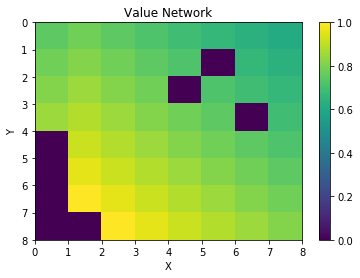

In [63]:
# Plot out the values the critic gives for the agent being in
# a specific state, i.e. in a specific location in the env.
def plot_value(initial_state):
    # Assume gridworld is always a square
    obs_sqr = math.sqrt(OBSERVATION_SPACE)
    np_w_cri_r = np.zeros((OBS_SQR,OBS_SQR))
    # make a working copy.
    working_state = initial_state.copy()
    for x in range(0,OBS_SQR):
        for y in range(0,OBS_SQR):
            my_state = working_state.copy()
            # Place the player at a given X/Y location.
            my_state[x,y] = 1
            obs_predict = my_state.reshape(1,OBSERVATION_SPACE,)
            obs_predict = np.squeeze(obs_predict)
            index, = np.where(obs_predict == 1.)
            value = np.max(q_ql[index,:])
            #value = 0
            np_w_cri_r[x,y] = value
    np_w_cri_r.shape
    pylab.pcolor(np_w_cri_r)
    pylab.title("Value Network")
    pylab.colorbar()
    pylab.xlabel("X")
    pylab.ylabel("Y")
    pylab.gca().invert_yaxis()
    pylab.draw()

env.reset()
env.render()
plot_value(STATEGRID)


FFFFFFFS
FFFFFHFF
FFFFHFFF
FFFFFFHF
HFFFFFFF
HFFFFFFF
HFFFFFFF
FGFFFFFF


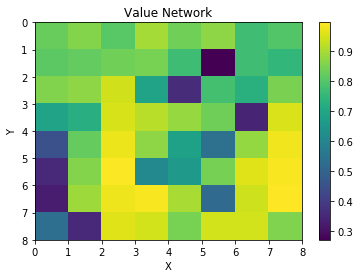

In [64]:
# Plot out the values the critic gives for the agent being in
# a specific state, i.e. in a specific location in the env.
def plot_value(initial_state):
    # Assume gridworld is always a square
    obs_sqr = math.sqrt(OBSERVATION_SPACE)
    np_w_cri_r = np.zeros((OBS_SQR,OBS_SQR))
    # make a working copy.
    working_state = initial_state.copy()
    for x in range(0,OBS_SQR):
        for y in range(0,OBS_SQR):
            my_state = working_state.copy()
            # Place the player at a given X/Y location.
            my_state[x,y] = 1
            obs_predict = my_state.reshape(1,OBSERVATION_SPACE,)
            obs_predict = np.squeeze(obs_predict)
            index, = np.where(obs_predict == 1.)
            value = np.max(q[index,:])
            #value = 0
            np_w_cri_r[x,y] = value
    np_w_cri_r.shape
    pylab.pcolor(np_w_cri_r)
    pylab.title("Value Network")
    pylab.colorbar()
    pylab.xlabel("X")
    pylab.ylabel("Y")
    pylab.gca().invert_yaxis()
    pylab.draw()

env.reset()
env.render()
plot_value(STATEGRID)

In [66]:
A2A=['<','v','>','^']
def show_policy(initial_state):
    grid = np.zeros((OBS_SQR,OBS_SQR), dtype='<U2')
    for x in range(0,OBS_SQR):
        for y in range(0,OBS_SQR):
            my_state = initial_state.copy()
            my_state[x,y] = 1

            obs_predict = my_state.reshape(1,OBSERVATION_SPACE,)
            obs_predict = np.squeeze(obs_predict)
            index, = np.where(obs_predict == 1.)
            action = np.argmax(q_ql[index,:])
            grid[x,y] = A2A[action]
    grid
    return grid

env.reset()
env.render()

grid = show_policy(STATEGRID)
print(grid)


FFFFFFFS
FFFFFHFF
FFFFHFFF
FFFFFFHF
HFFFFFFF
HFFFFFFF
HFFFFFFF
FGFFFFFF
[[u'v' u'v' u'<' u'<' u'<' u'<' u'<' u'<']
 [u'v' u'v' u'<' u'<' u'<' u'<' u'v' u'<']
 [u'v' u'v' u'<' u'<' u'<' u'v' u'<' u'<']
 [u'>' u'v' u'<' u'<' u'<' u'<' u'<' u'v']
 [u'<' u'v' u'<' u'<' u'<' u'<' u'<' u'<']
 [u'<' u'v' u'<' u'<' u'<' u'<' u'<' u'<']
 [u'<' u'v' u'<' u'<' u'<' u'<' u'<' u'<']
 [u'<' u'<' u'<' u'<' u'<' u'<' u'<' u'<']]


In [67]:
def show_policy(q):
    A2A=['<','v','>','^']
    grid = np.zeros(64, dtype='<U2')
    for index in xrange(64):
        action = np.argmax(q[index,:])
        grid[index] = A2A[action]
    grid = np.reshape(grid, (8, 8), order='C')
    return grid

In [68]:
show_policy(q_ql)

array([[u'v', u'v', u'<', u'<', u'<', u'<', u'<', u'<'],
       [u'v', u'v', u'<', u'<', u'<', u'<', u'v', u'<'],
       [u'v', u'v', u'<', u'<', u'<', u'v', u'<', u'<'],
       [u'>', u'v', u'<', u'<', u'<', u'<', u'<', u'v'],
       [u'<', u'v', u'<', u'<', u'<', u'<', u'<', u'<'],
       [u'<', u'v', u'<', u'<', u'<', u'<', u'<', u'<'],
       [u'<', u'v', u'<', u'<', u'<', u'<', u'<', u'<'],
       [u'<', u'<', u'<', u'<', u'<', u'<', u'<', u'<']], dtype='<U2')

In [69]:
%%time
q_improved, rpe_iproved, _, _ = trainer(epochs=200,Q=q)

Game #: 200
Moves this round 7
Final Position:
  (Left)
FFFFFFFS
FFFFFHFF
FFFFHFFF
FFFFFFHF
HFFFFFFF
HFFFFFFF
HFFFFFFF
FGFFFFFF
Wins/Losses 7/193
CPU times: user 1.76 s, sys: 469 ms, total: 2.23 s
Wall time: 22.1 s


In [70]:
show_policy(q_improved)

array([[u'v', u'>', u'v', u'v', u'<', u'<', u'v', u'v'],
       [u'>', u'>', u'v', u'v', u'<', u'^', u'v', u'v'],
       [u'<', u'>', u'v', u'v', u'>', u'v', u'<', u'<'],
       [u'^', u'>', u'v', u'v', u'<', u'v', u'>', u'v'],
       [u'<', u'>', u'v', u'v', u'v', u'v', u'<', u'v'],
       [u'>', u'>', u'v', u'<', u'<', u'<', u'<', u'<'],
       [u'<', u'>', u'v', u'<', u'v', u'<', u'<', u'<'],
       [u'>', u'v', u'<', u'<', u'<', u'<', u'<', u'^']], dtype='<U2')

In [71]:
show_policy(q_ql)

array([[u'v', u'v', u'<', u'<', u'<', u'<', u'<', u'<'],
       [u'v', u'v', u'<', u'<', u'<', u'<', u'v', u'<'],
       [u'v', u'v', u'<', u'<', u'<', u'v', u'<', u'<'],
       [u'>', u'v', u'<', u'<', u'<', u'<', u'<', u'v'],
       [u'<', u'v', u'<', u'<', u'<', u'<', u'<', u'<'],
       [u'<', u'v', u'<', u'<', u'<', u'<', u'<', u'<'],
       [u'<', u'v', u'<', u'<', u'<', u'<', u'<', u'<'],
       [u'<', u'<', u'<', u'<', u'<', u'<', u'<', u'<']], dtype='<U2')


FFFFFFFS
FFFFFHFF
FFFFHFFF
FFFFFFHF
HFFFFFFF
HFFFFFFF
HFFFFFFF
FGFFFFFF


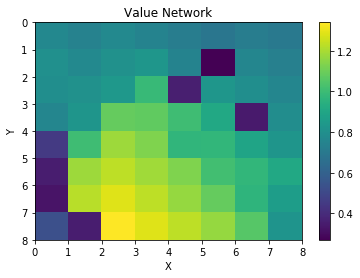

In [74]:
# Plot out the values the critic gives for the agent being in
# a specific state, i.e. in a specific location in the env.
def plot_value(initial_state):
    # Assume gridworld is always a square
    obs_sqr = math.sqrt(OBSERVATION_SPACE)
    np_w_cri_r = np.zeros((OBS_SQR,OBS_SQR))
    # make a working copy.
    working_state = initial_state.copy()
    for x in range(0,OBS_SQR):
        for y in range(0,OBS_SQR):
            my_state = working_state.copy()
            # Place the player at a given X/Y location.
            my_state[x,y] = 1
            obs_predict = my_state.reshape(1,OBSERVATION_SPACE,)
            obs_predict = np.squeeze(obs_predict)
            index, = np.where(obs_predict == 1.)
            value = np.max(q_improved[index,:])
            #value = 0
            np_w_cri_r[x,y] = value
    np_w_cri_r.shape
    pylab.pcolor(np_w_cri_r)
    pylab.title("Value Network")
    pylab.colorbar()
    pylab.xlabel("X")
    pylab.ylabel("Y")
    pylab.gca().invert_yaxis()
    pylab.draw()

env.reset()
env.render()
plot_value(STATEGRID)

## Comparing from scratch with just 200 games

In [75]:
%%time
q_naive, rpe_naive, _, _ = trainer(epochs=200)

Game #: 200
Moves this round 22
Final Position:
  (Down)
FFFFFFFS
FFFFFHFF
FFFFHFFF
FFFFFFHF
HFFFFFFF
HFFFFFFF
HFFFFFFF
FGFFFFFF
Wins/Losses 12/188
CPU times: user 1.68 s, sys: 460 ms, total: 2.14 s
Wall time: 22 s



FFFFFFFG
FFFFFHFF
FFFFHFFF
FFFFFFHF
HFFFFFFF
HFFFFFFF
HFFFFFFF
FSFFFFFF


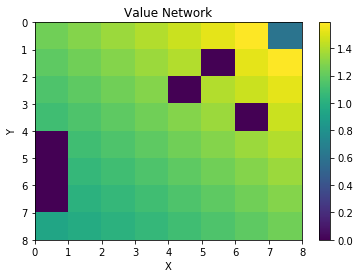

In [103]:
# Plot out the values the critic gives for the agent being in
# a specific state, i.e. in a specific location in the env.
def plot_value(initial_state):
    # Assume gridworld is always a square
    obs_sqr = math.sqrt(OBSERVATION_SPACE)
    np_w_cri_r = np.zeros((OBS_SQR,OBS_SQR))
    # make a working copy.
    working_state = initial_state.copy()
    for x in range(0,OBS_SQR):
        for y in range(0,OBS_SQR):
            my_state = working_state.copy()
            # Place the player at a given X/Y location.
            my_state[x,y] = 1
            obs_predict = my_state.reshape(1,OBSERVATION_SPACE,)
            obs_predict = np.squeeze(obs_predict)
            index, = np.where(obs_predict == 1.)
            value = np.max(q_ql[index,:])
            #value = 0
            np_w_cri_r[x,y] = value
    np_w_cri_r.shape
    pylab.pcolor(np_w_cri_r)
    pylab.title("Value Network")
    pylab.colorbar()
    pylab.xlabel("X")
    pylab.ylabel("Y")
    pylab.gca().invert_yaxis()
    pylab.draw()

env.reset()
env.render()
plot_value(STATEGRID)

In [82]:
show_policy(q_naive)

array([[u'v', u'v', u'<', u'<', u'<', u'<', u'<', u'<'],
       [u'v', u'v', u'<', u'<', u'<', u'<', u'v', u'<'],
       [u'v', u'v', u'<', u'<', u'<', u'v', u'<', u'<'],
       [u'>', u'v', u'<', u'<', u'<', u'<', u'<', u'v'],
       [u'<', u'v', u'<', u'<', u'<', u'<', u'<', u'<'],
       [u'<', u'v', u'<', u'<', u'<', u'<', u'<', u'<'],
       [u'<', u'v', u'<', u'<', u'<', u'<', u'<', u'<'],
       [u'<', u'<', u'<', u'<', u'<', u'<', u'<', u'<']], dtype='<U2')

# Test UP

In [85]:
from gym.envs.registration import register, spec

MY_ENV_NAME='FrozenLakeNonskid8x8-v1'
register(
        id=MY_ENV_NAME,
        entry_point='myfrozen.frozen_testup:FrozenLakeEnv',
        kwargs={'map_name': '8x8', 'is_slippery': False},
        timestep_limit=100,
        reward_threshold=0.78, # optimum = .8196
)

env = gym.make(MY_ENV_NAME)

In [86]:
env.render()


FFFFFFFG
FFFFFHFF
FFFFHFFF
FFFFFFHF
HFFFFFFF
HFFFFFFF
HFFFFFFF
FSFFFFFF


In [87]:
%%time
q_up, _, _, _ = trainer(epochs=2000)

Game #: 2000
Moves this round 62
Final Position:
  (Left)
FFFFFFFG
FFFFFHFF
FFFFHFFF
FFFFFFHF
HFFFFFFF
HFFFFFFF
HFFFFFFF
FSFFFFFF
Wins/Losses 274/1726
CPU times: user 20.5 s, sys: 5.9 s, total: 26.4 s
Wall time: 3min 45s
